## 1. Setup and Data Loading

In [1]:
# Import required libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append('../src')

# Import our custom modules
from preprocess import TwitterDataPreprocessor
from build_graph import TemporalGraphBuilder
from sentiment_analysis import TwitterSentimentAnalyzer
from visualization import TwitterVisualization

# Standard libraries
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')

print("✅ All modules imported successfully!")
print(f"📅 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All modules imported successfully!
📅 Analysis started at: 2025-06-28 22:06:10


## 2. Data Preprocessing

In [2]:
# Initialize data preprocessor
print("🔄 Loading and preprocessing Twitter data...")
preprocessor = TwitterDataPreprocessor("../data/tweetdata-en.csv")

# Load the dataset
raw_data = preprocessor.load_data()

# Check if data loaded successfully
if raw_data is None:
    print("❌ Failed to load data. Please check the file path.")
else:
    # Display basic dataset information
    print(f"\n📊 Dataset Overview:")
    print(f"Total tweets: {len(raw_data):,}")
    print(f"Columns: {list(raw_data.columns)}")

    # Check date range using the actual column name
    if 'createdAt' in raw_data.columns:
        # Parse dates to get proper range
        dates = pd.to_datetime(raw_data['createdAt'], errors='coerce')
        print(f"Date range: {dates.min()} to {dates.max()}")
        print(f"Valid dates: {dates.notna().sum():,}")
    else:
        print("Date column 'createdAt' not found")

    # Show basic data info
    print(f"\nData types overview:")
    print(f"  Text field: {raw_data['text'].dtype}")
    print(f"  Author field: {raw_data['author'].dtype}")
    print(f"  Date field: {raw_data['createdAt'].dtype}")

    # Extract sample user info for display
    print("\n📋 Sample tweets with user info:")
    sample_data = []
    for idx in range(min(5, len(raw_data))):
        row = raw_data.iloc[idx]
        
        # Extract user info from author field
        author_info = preprocessor.parse_author_info(row.get('author', ''))
        
        sample_data.append({
            'tweet_id': str(row.get('id', 'N/A')),
            'user_id': author_info.get('user_id', 'N/A'),
            'username': author_info.get('username', 'N/A'),
            'text': str(row.get('text', ''))[:80] + '...' if len(str(row.get('text', ''))) > 80 else str(row.get('text', '')),
            'created_at': str(row.get('createdAt', 'N/A'))[:19],  # Truncate timestamp
            'is_reply': row.get('isReply', False),
            'is_quote': row.get('isQuote', False),
            'like_count': row.get('likeCount', 0),
            'retweet_count': row.get('retweetCount', 0)
        })

    # Display as DataFrame for better formatting
    sample_df = pd.DataFrame(sample_data)
    print(sample_df[['username', 'text', 'like_count']].to_string(index=False))

    # Show interaction statistics
    print(f"\n🔗 Interaction Overview:")
    print(f"  Total tweets: {len(raw_data):,}")
    print(f"  Replies: {raw_data['isReply'].sum() if 'isReply' in raw_data.columns else 'N/A'}")
    print(f"  Quotes: {raw_data['isQuote'].sum() if 'isQuote' in raw_data.columns else 'N/A'}")
    print(f"  Has reply-to info: {raw_data['inReplyToUserId'].notna().sum() if 'inReplyToUserId' in raw_data.columns else 'N/A'}")

    # Show engagement statistics
    engagement_cols = ['retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'viewCount']
    print(f"\n📊 Engagement Statistics:")
    for col in engagement_cols:
        if col in raw_data.columns:
            mean_val = raw_data[col].mean()
            max_val = raw_data[col].max()
            print(f"  {col:<15}: avg {mean_val:.1f}, max {max_val:,}")

    # Show sample author field structure
    print(f"\n👤 Sample Author Field Structure:")
    if not raw_data['author'].isna().all():
        sample_author = raw_data['author'].dropna().iloc[0]
        print(f"Type: {type(sample_author)}")
        print(f"Sample content (first 200 chars): {str(sample_author)[:200]}...")
        
        # Test parsing
        test_parse = preprocessor.parse_author_info(sample_author)
        print(f"Parsed result: {test_parse}")

🔄 Loading and preprocessing Twitter data...
✅ Loaded 14,189 tweets from ../data/tweetdata-en.csv
📋 Columns available: ['Unnamed: 0', 'type', 'id', 'url', 'twitterUrl', 'text', 'source', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'viewCount', 'createdAt', 'lang', 'bookmarkCount', 'isReply', 'inReplyToId', 'conversationId', 'inReplyToUserId', 'inReplyToUsername', 'isPinned', 'author', 'extendedEntities', 'card', 'place', 'entities', 'reply_to_user_results', 'quoted_tweet_results', 'quoted_tweet', 'retweeted_tweet', 'isConversationControlled', 'searchTermIndex', 'isQuote']

📊 Dataset Overview:
Total tweets: 14,189
Columns: ['Unnamed: 0', 'type', 'id', 'url', 'twitterUrl', 'text', 'source', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'viewCount', 'createdAt', 'lang', 'bookmarkCount', 'isReply', 'inReplyToId', 'conversationId', 'inReplyToUserId', 'inReplyToUsername', 'isPinned', 'author', 'extendedEntities', 'card', 'place', 'entities', 'reply_to_user_results', 'q

In [3]:
# Process data and extract users/interactions
print("\n🔄 Processing data and extracting interactions...")
users, interactions = preprocessor.process_data(filter_business=False)

print(f"\n✅ Data Processing Complete:")
print(f"👥 Unique users extracted: {len(users):,}")
print(f"🔗 Valid interactions found: {len(interactions):,}")

# Show interaction type breakdown
interaction_types = {}
for interaction in interactions:
    edge_type = interaction['edge_type']
    interaction_types[edge_type] = interaction_types.get(edge_type, 0) + 1

print("\n📈 Interaction Type Distribution:")
for edge_type, count in sorted(interaction_types.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(interactions)) * 100
    print(f"  {edge_type.capitalize()}: {count:,} ({percentage:.1f}%)")

# Display sample users
print("\n👤 Sample User Profiles:")
sample_users = list(users.items())[:5]
for user_id, user_info in sample_users:
    print(f"  @{user_info['username']}: {user_info['followers_count']:,} followers, {user_info['name']}")


🔄 Processing data and extracting interactions...
📤 Extracting user information...
👥 Extracted 8053 new users, total: 8053
🔗 Extracting interactions...
📊 Extracted 14590 total interactions
✅ Processing complete:
   Users: 8,053
   Valid interactions: 1,824
   Removed invalid interactions: 12,766

📈 Interaction type breakdown:
   Mention: 1,824 (100.0%)

✅ Data Processing Complete:
👥 Unique users extracted: 8,053
🔗 Valid interactions found: 1,824

📈 Interaction Type Distribution:
  Mention: 1,824 (100.0%)

👤 Sample User Profiles:
  @isutechzone: 699 followers, TechZone
  @ichbinichnich: 44 followers, Gabi Peyn
  @newslisted: 103 followers, News
  @bruhitsapple: 584 followers, apple
  @solarheavy: 67,311 followers, Solar Heavy


In [4]:
sample_df

,tweet_id,user_id,username,text,created_at,is_reply,is_quote,like_count,retweet_count
0,1914345833962623232,120966905,isutechzone,Stream lectures or bring your next big idea to...,Mon Apr 21 15:49:48,False,NaN,0,0
1,1914345810310971648,1875345057479614464,ichbinichnich,@kirrakaye Wtf is your phone its not samsung n...,Mon Apr 21 15:49:42,True,NaN,0,0
2,1914345806901248000,1347831450486284289,newslisted,🚨 Big Tech Just Got a Reality Check 🚨\n\nApple...,Mon Apr 21 15:49:41,False,NaN,0,0
3,1914345782440067072,467076981,bruhitsapple,Do girls not know about Bobby pins?,Mon Apr 21 15:49:36,False,1.0,0,0
4,1857081181352702208,3479135658,solarheavy,you like edm with guitar in it?,Thu Nov 14 15:20:31,False,NaN,2185,85


## 3. Temporal Graph Construction

In [4]:
# Initialize graph builder
print("🔄 Building temporal social graphs...")
graph_builder = TemporalGraphBuilder(users, interactions)

# Create the full network graph
full_graph = graph_builder.create_full_graph()

# Get basic network statistics
network_stats = graph_builder.get_network_statistics()
print(f"\n📊 Network Statistics:")
for metric, value in network_stats.items():
    if isinstance(value, float):
        print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"  {metric.replace('_', ' ').title()}: {value:,}")

🔄 Building temporal social graphs...
Created full graph with 8053 nodes and 1561 edges

📊 Network Statistics:
  Nodes: 8,053
  Edges: 1,561
  Average Clustering: 0.0112
  Average Degree: 0.3877
  Max Degree: 94
  Min Degree: 0


In [5]:
# Create temporal snapshots
print("\n🔄 Creating daily temporal snapshots...")
temporal_graphs = graph_builder.create_temporal_snapshots(interval='daily')

print(f"\n⏰ Temporal Analysis:")
print(f"  Total snapshots created: {len(temporal_graphs)}")
print(f"  Time range: {min(temporal_graphs.keys())} to {max(temporal_graphs.keys())}")

# Show snapshot statistics
snapshot_stats = []
for time_key, graph in temporal_graphs.items():
    snapshot_stats.append({
        'date': time_key,
        'nodes': graph.number_of_nodes(),
        'edges': graph.number_of_edges(),
        'density': nx.density(graph)
    })

snapshot_df = pd.DataFrame(snapshot_stats)
print(f"\n📈 Temporal Snapshot Summary:")
print(f"  Average nodes per day: {snapshot_df['nodes'].mean():.1f}")
print(f"  Average edges per day: {snapshot_df['edges'].mean():.1f}")
print(f"  Average density: {snapshot_df['density'].mean():.4f}")

# Display top active days
top_days = snapshot_df.nlargest(5, 'edges')
print(f"\n🔥 Most Active Days (by interactions):")
for _, row in top_days.iterrows():
    print(f"  {row['date']}: {row['edges']} interactions, {row['nodes']} users")


🔄 Creating daily temporal snapshots...
Creating temporal snapshots from 2024-11-13 19:21:59+00:00 to 2025-04-21 15:48:21+00:00
Found 91 unique days in data
  2025-04-21: 290 interactions, hours: [0, 8, 9, 11, 12, 14, 15]...
  2025-01-24: 8 interactions, hours: [0, 3, 5, 11, 16, 18]...
  2024-11-15: 5 interactions, hours: [2]...
  2024-11-13: 5 interactions, hours: [19]...
  2025-04-20: 21 interactions, hours: [1, 4, 6, 7, 9, 10, 13, 16, 17, 18]...
  2025-04-19: 11 interactions, hours: [0, 5, 7, 11, 16, 18, 19, 22]...
  2025-04-18: 28 interactions, hours: [0, 5, 6, 7, 8, 9, 10, 11, 12, 16]...
  2025-04-17: 18 interactions, hours: [0, 3, 6, 12, 13, 14, 15, 18, 19, 20]...
  2025-04-16: 43 interactions, hours: [2, 3, 4, 5, 6, 7, 8, 9, 10, 13]...
  2025-04-15: 14 interactions, hours: [0, 3, 4, 5, 10, 16, 17, 18, 19]...
  2025-04-14: 37 interactions, hours: [2, 3, 5, 6, 7, 10, 11, 16, 17, 19]...
  2025-04-13: 16 interactions, hours: [0, 5, 9, 11, 12, 14, 15, 16, 19, 23]...
  2025-04-12: 15 

## 4. Centrality Analysis and Influence Ranking

In [32]:
# Calculate centrality metrics
print("🔄 Calculating centrality metrics...")
centrality_metrics = graph_builder.calculate_centrality_metrics()

# Get top influential users by different metrics
influence_metrics = ['pagerank', 'in_degree_centrality', 'out_degree_centrality']

print("\n🏆 Top Influential Users by Different Met  grics:")
for metric in influence_metrics:
    print(f"\n📊 Top 10 by {metric.replace('_', ' ').title()}:")
    top_users = graph_builder.get_influential_users(top_k=10, metric=metric)
    
    for i, (user_id, score) in enumerate(top_users, 1):
        user_info = users.get(user_id, {})
        username = user_info.get('username', 'unknown')
        name = user_info.get('name', 'Unknown')
        followers = user_info.get('followers_count', 0)
        print(f"  {i:2d}. @{username:<15} | {name:<20} | {score:.4f} | {followers:,} followers")

🔄 Calculating centrality metrics...

🏆 Top Influential Users by Different Met  grics:

📊 Top 10 by Pagerank:
   1. @markgurman      | Mark Gurman          | 0.0116 | 407,404 followers
   2. @datruthdt       | DaTruthDT            | 0.0057 | 263,932 followers
   3. @theapplehub     | Apple Hub            | 0.0043 | 1,185,790 followers
   4. @sinnybd         | ❄️SinnyBD❄️          | 0.0034 | 1,693 followers
   5. @grok            | Grok                 | 0.0034 | 3,469,363 followers
   6. @eth_apple       | APPLE🔺L1             | 0.0030 | 185,702 followers
   7. @passi0n03       | y - Passion (1-0)    | 0.0030 | 1,399 followers
   8. @macrumors       | MacRumors.com        | 0.0026 | 1,340,159 followers
   9. @ronin_network   | Ronin                | 0.0025 | 266,863 followers
  10. @gaminggridx     | GamingGrid 💎         | 0.0025 | 22,982 followers

📊 Top 10 by In Degree Centrality:
   1. @markgurman      | Mark Gurman          | 0.0117 | 407,404 followers
   2. @datruthdt       | DaTru

In [33]:
# Add this new cell after your centrality analysis
print("🎯 INFLUENCER RECOMMENDATION SYSTEM")
print("=" * 70)

# Get comprehensive influencer data
def analyze_influencers_for_recommendations():
    """Analyze influencers and provide actionable recommendations"""
    
    # Get top users by different metrics
    top_pagerank = graph_builder.get_influential_users(top_k=20, metric='pagerank')
    top_in_degree = graph_builder.get_influential_users(top_k=20, metric='in_degree_centrality')
    top_out_degree = graph_builder.get_influential_users(top_k=20, metric='out_degree_centrality')
    
    # Create comprehensive influencer profiles
    influencer_profiles = {}
    
    # Combine all top users
    all_influential_users = set()
    for users_list in [top_pagerank, top_in_degree, top_out_degree]:
        for user_id, score in users_list:
            all_influential_users.add(user_id)
    
    # Build detailed profiles
    for user_id in all_influential_users:
        user_info = users.get(user_id, {})
        centrality_data = centrality_metrics.get(user_id, {})
        
        # Calculate influencer score components
        pagerank_score = centrality_data.get('pagerank', 0)
        in_degree_score = centrality_data.get('in_degree_centrality', 0)
        out_degree_score = centrality_data.get('out_degree_centrality', 0)
        betweenness_score = centrality_data.get('betweenness_centrality', 0)
        
        # Follower count and engagement
        followers = user_info.get('followers_count', 0)
        username = user_info.get('username', 'unknown')
        name = user_info.get('name', 'Unknown')
        
        # Calculate composite influence score
        composite_score = (
            pagerank_score * 0.4 +          # Overall influence
            in_degree_score * 0.3 +         # Popularity/Reach
            out_degree_score * 0.2 +        # Activity level
            betweenness_score * 0.1         # Bridge connections
        )
        
        # Determine influencer type
        influencer_type = categorize_influencer(pagerank_score, in_degree_score, 
                                              out_degree_score, followers)
        
        # Calculate engagement ratio
        engagement_ratio = calculate_engagement_ratio(user_id, followers)
        
        influencer_profiles[user_id] = {
            'username': username,
            'name': name,
            'followers_count': followers,
            'pagerank': pagerank_score,
            'in_degree_centrality': in_degree_score,
            'out_degree_centrality': out_degree_score,
            'betweenness_centrality': betweenness_score,
            'composite_score': composite_score,
            'influencer_type': influencer_type,
            'engagement_ratio': engagement_ratio,
            'recommendation_priority': calculate_priority(composite_score, followers, engagement_ratio)
        }
    
    return influencer_profiles

def categorize_influencer(pagerank, in_degree, out_degree, followers):
    """Categorize influencer based on metrics"""
    
    if pagerank > 0.01 and followers > 10000:
        return "🌟 Mega Influencer"
    elif pagerank > 0.005 and in_degree > 0.01:
        return "🎯 Authority Figure"
    elif out_degree > 0.02 and in_degree > 0.005:
        return "💬 Conversation Starter"
    elif in_degree > out_degree * 2:
        return "📢 Content Amplifier"
    elif out_degree > in_degree * 2:
        return "🔗 Community Connector"
    elif followers > 1000:
        return "👤 Niche Influencer"
    else:
        return "🌱 Emerging Voice"

def calculate_engagement_ratio(user_id, followers):
    """Calculate engagement ratio based on interactions"""
    if followers == 0:
        return 0
    
    # Count interactions involving this user
    user_interactions = sum(1 for interaction in interactions 
                          if interaction['source_user_id'] == user_id or 
                             interaction['target_user_id'] == user_id)
    
    # Normalize by followers (engagement rate)
    return min(user_interactions / max(followers, 1) * 1000, 100)  # Cap at 100

def calculate_priority(composite_score, followers, engagement_ratio):
    """Calculate recommendation priority"""
    
    # Weighted priority score
    priority_score = (
        composite_score * 50 +           # Network influence (0-50 points)
        min(followers / 1000, 30) +     # Follower reach (0-30 points)
        engagement_ratio * 0.2          # Engagement quality (0-20 points)
    )
    
    if priority_score >= 70:
        return "🔥 TOP PRIORITY"
    elif priority_score >= 50:
        return "⭐ HIGH PRIORITY"
    elif priority_score >= 30:
        return "📈 MEDIUM PRIORITY"
    else:
        return "🌱 LOW PRIORITY"

# Execute analysis
influencer_profiles = analyze_influencers_for_recommendations()

# Sort by composite score
sorted_influencers = sorted(influencer_profiles.items(), 
                          key=lambda x: x[1]['composite_score'], reverse=True)

print(f"\n📊 ANALYZED {len(influencer_profiles)} INFLUENTIAL USERS")
print("\n🏆 TOP 15 RECOMMENDED INFLUENCERS:")
print("-" * 120)

for i, (user_id, profile) in enumerate(sorted_influencers[:15], 1):
    print(f"{i:2d}. @{profile['username']:<15} | {profile['name']:<20}")
    print(f"    {profile['influencer_type']:<20} | {profile['recommendation_priority']}")
    print(f"    👥 {profile['followers_count']:,} followers | 🎯 Composite Score: {profile['composite_score']:.4f}")
    print(f"    📊 PageRank: {profile['pagerank']:.4f} | 📈 Engagement: {profile['engagement_ratio']:.1f}")
    print("-" * 120)

# Categorized recommendations
print(f"\n🎯 INFLUENCER STRATEGY RECOMMENDATIONS:")
print("=" * 70)

# Group by priority
priority_groups = {}
for user_id, profile in influencer_profiles.items():
    priority = profile['recommendation_priority']
    if priority not in priority_groups:
        priority_groups[priority] = []
    priority_groups[priority].append(profile)

# TOP PRIORITY recommendations
if "🔥 TOP PRIORITY" in priority_groups:
    top_priority = priority_groups["🔥 TOP PRIORITY"]
    print(f"\n🔥 TOP PRIORITY INFLUENCERS ({len(top_priority)} users)")
    print("   💡 RECOMMENDATION: Prime candidates for major campaigns")
    print("   🎯 STRATEGY: Exclusive partnerships, product launches, brand ambassadorships")
    print("   💰 INVESTMENT: High budget allocation recommended")
    
    for profile in sorted(top_priority, key=lambda x: x['composite_score'], reverse=True)[:5]:
        print(f"     • @{profile['username']} ({profile['influencer_type'].split()[1]} - {profile['followers_count']:,} followers)")

# HIGH PRIORITY recommendations  
if "⭐ HIGH PRIORITY" in priority_groups:
    high_priority = priority_groups["⭐ HIGH PRIORITY"]
    print(f"\n⭐ HIGH PRIORITY INFLUENCERS ({len(high_priority)} users)")
    print("   💡 RECOMMENDATION: Strong candidates for targeted campaigns")
    print("   🎯 STRATEGY: Sponsored content, product reviews, collaborative content")
    print("   💰 INVESTMENT: Medium to high budget allocation")

# MEDIUM PRIORITY recommendations
if "📈 MEDIUM PRIORITY" in priority_groups:
    medium_priority = priority_groups["📈 MEDIUM PRIORITY"]
    print(f"\n📈 MEDIUM PRIORITY INFLUENCERS ({len(medium_priority)} users)")
    print("   💡 RECOMMENDATION: Good for niche targeting and community building")
    print("   🎯 STRATEGY: Micro-campaigns, user-generated content, community engagement")
    print("   💰 INVESTMENT: Medium budget allocation")

# Campaign-specific recommendations
print(f"\n📱 CAMPAIGN-SPECIFIC RECOMMENDATIONS:")
print("=" * 70)

# Mega Influencers for Brand Awareness
mega_influencers = [p for p in influencer_profiles.values() if "Mega" in p['influencer_type']]
if mega_influencers:
    print(f"\n🌟 BRAND AWARENESS CAMPAIGNS:")
    print(f"   Target Mega Influencers: {len(mega_influencers)} identified")
    for profile in sorted(mega_influencers, key=lambda x: x['followers_count'], reverse=True)[:3]:
        print(f"     • @{profile['username']} - {profile['followers_count']:,} followers")
    print("   💡 Best for: Product launches, brand announcements, mass market reach")

# Authority Figures for Credibility
authorities = [p for p in influencer_profiles.values() if "Authority" in p['influencer_type']]
if authorities:
    print(f"\n🎯 CREDIBILITY & TRUST CAMPAIGNS:")
    print(f"   Target Authority Figures: {len(authorities)} identified")
    for profile in sorted(authorities, key=lambda x: x['pagerank'], reverse=True)[:3]:
        print(f"     • @{profile['username']} - PageRank: {profile['pagerank']:.4f}")
    print("   💡 Best for: Product endorsements, expert reviews, thought leadership")

# Conversation Starters for Engagement
conversationalists = [p for p in influencer_profiles.values() if "Conversation" in p['influencer_type']]
if conversationalists:
    print(f"\n💬 ENGAGEMENT & COMMUNITY CAMPAIGNS:")
    print(f"   Target Conversation Starters: {len(conversationalists)} identified")
    for profile in sorted(conversationalists, key=lambda x: x['engagement_ratio'], reverse=True)[:3]:
        print(f"     • @{profile['username']} - Engagement: {profile['engagement_ratio']:.1f}")
    print("   💡 Best for: Interactive campaigns, Q&A sessions, community building")

# ROI Optimization suggestions
print(f"\n💰 ROI OPTIMIZATION STRATEGIES:")
print("=" * 70)

# High engagement, lower follower accounts (micro-influencers)
micro_influencers = [p for p in influencer_profiles.values() 
                    if p['followers_count'] < 10000 and p['engagement_ratio'] > 5]

if micro_influencers:
    print(f"\n🎯 MICRO-INFLUENCER STRATEGY:")
    print(f"   High-engagement, lower-cost options: {len(micro_influencers)} identified")
    print("   💡 ADVANTAGE: Higher engagement rates, lower costs, authentic connections")
    print("   🎯 IDEAL FOR: Niche products, local campaigns, authentic testimonials")
    
    top_micro = sorted(micro_influencers, key=lambda x: x['engagement_ratio'], reverse=True)[:3]
    for profile in top_micro:
        print(f"     • @{profile['username']} - {profile['followers_count']:,} followers, {profile['engagement_ratio']:.1f} engagement")

# Budget allocation suggestions
total_top_priority = len(priority_groups.get("🔥 TOP PRIORITY", []))
total_high_priority = len(priority_groups.get("⭐ HIGH PRIORITY", []))
total_medium_priority = len(priority_groups.get("📈 MEDIUM PRIORITY", []))

print(f"\n💸 SUGGESTED BUDGET ALLOCATION:")
print(f"   🔥 Top Priority ({total_top_priority} users): 50-60% of influencer budget")
print(f"   ⭐ High Priority ({total_high_priority} users): 25-30% of influencer budget") 
print(f"   📈 Medium Priority ({total_medium_priority} users): 15-20% of influencer budget")

print(f"\n✅ INFLUENCER ANALYSIS COMPLETE!")
print(f"📊 Detailed recommendations saved for {len(influencer_profiles)} influential users")

🎯 INFLUENCER RECOMMENDATION SYSTEM

📊 ANALYZED 38 INFLUENTIAL USERS

🏆 TOP 15 RECOMMENDED INFLUENCERS:
------------------------------------------------------------------------------------------------------------------------
 1. @markgurman      | Mark Gurman         
    🌟 Mega Influencer    | 📈 MEDIUM PRIORITY
    👥 407,404 followers | 🎯 Composite Score: 0.0082
    📊 PageRank: 0.0116 | 📈 Engagement: 0.3
------------------------------------------------------------------------------------------------------------------------
 2. @datruthdt       | DaTruthDT           
    📢 Content Amplifier  | 📈 MEDIUM PRIORITY
    👥 263,932 followers | 🎯 Composite Score: 0.0048
    📊 PageRank: 0.0057 | 📈 Engagement: 0.4
------------------------------------------------------------------------------------------------------------------------
 3. @theapplehub     | Apple Hub           
    📢 Content Amplifier  | 📈 MEDIUM PRIORITY
    👥 1,185,790 followers | 🎯 Composite Score: 0.0036
    📊 PageRank: 0.0043 

In [34]:
# Analyze temporal influence patterns
print("\n🔄 Analyzing temporal influence patterns...")
temporal_influence_df = graph_builder.analyze_temporal_influence()

if not temporal_influence_df.empty:
    print(f"\n⏰ Temporal Influence Analysis:")
    print(f"  Total user-time observations: {len(temporal_influence_df):,}")
    print(f"  Unique users tracked: {temporal_influence_df['user_id'].nunique():,}")
    print(f"  Time periods: {temporal_influence_df['timestamp'].nunique()}")
    
    # Show users with most consistent high influence
    user_avg_influence = temporal_influence_df.groupby('user_id')['pagerank'].agg(['mean', 'std', 'count']).reset_index()
    user_avg_influence['consistency'] = user_avg_influence['mean'] / (user_avg_influence['std'] + 0.001)  # Avoid division by zero
    
    most_consistent = user_avg_influence[user_avg_influence['count'] >= 3].nlargest(10, 'consistency')
    print(f"\n🎯 Most Consistently Influential Users:")
    for _, row in most_consistent.iterrows():
        user_info = users.get(row['user_id'], {})
        username = user_info.get('username', 'unknown')
        print(f"  @{username:<15} | Avg: {row['mean']:.4f} | Consistency: {row['consistency']:.2f}")
else:
    print("❌ No temporal influence data available")


🔄 Analyzing temporal influence patterns...

⏰ Temporal Influence Analysis:
  Total user-time observations: 2,168
  Unique users tracked: 1,243
  Time periods: 90

🎯 Most Consistently Influential Users:
  @lakshyalark     | Avg: 0.0245 | Consistency: 7.71
  @axellont1       | Avg: 0.0988 | Consistency: 6.58
  @kanthan2030     | Avg: 0.0733 | Consistency: 4.68
  @num1mephilesfan | Avg: 0.0272 | Consistency: 4.22
  @sdw             | Avg: 0.0447 | Consistency: 4.08
  @marionawfal     | Avg: 0.0497 | Consistency: 3.54
  @tylerdbzboi     | Avg: 0.0154 | Consistency: 3.48
  @twostraws       | Avg: 0.0446 | Consistency: 3.46
  @paytondev       | Avg: 0.0279 | Consistency: 3.33
  @finsavvymike    | Avg: 0.0196 | Consistency: 3.23


## 5. Community Detection

In [35]:
# Detect communities
print("🔄 Detecting communities using modularity optimization...")
communities = graph_builder.detect_communities()

if communities:
    # Analyze community structure
    community_sizes = pd.Series(communities.values()).value_counts().sort_values(ascending=False)
    
    print(f"\n🏘️ Community Detection Results:")
    print(f"  Total communities found: {len(community_sizes)}")
    print(f"  Largest community: {community_sizes.iloc[0]} users")
    print(f"  Smallest community: {community_sizes.iloc[-1]} users")
    print(f"  Average community size: {community_sizes.mean():.1f} users")
    
    print(f"\n📊 Community Size Distribution:")
    for i, (community_id, size) in enumerate(community_sizes.head(10).items()):
        print(f"  Community {community_id}: {size} users")
    
    # Show sample users from largest communities
    print(f"\n👥 Sample Users from Largest Communities:")
    for community_id in community_sizes.head(3).index:
        community_users = [user_id for user_id, comm_id in communities.items() if comm_id == community_id]
        sample_users = community_users[:5]  # Show first 5 users
        
        print(f"\n  Community {community_id} ({len(community_users)} users):")
        for user_id in sample_users:
            user_info = users.get(user_id, {})
            username = user_info.get('username', 'unknown')
            name = user_info.get('name', 'Unknown')
            print(f"    @{username} - {name}")
else:
    print("❌ No communities detected")

🔄 Detecting communities using modularity optimization...
Detected 6850 communities

🏘️ Community Detection Results:
  Total communities found: 6850
  Largest community: 155 users
  Smallest community: 1 users
  Average community size: 1.2 users

📊 Community Size Distribution:
  Community 0: 155 users
  Community 1: 133 users
  Community 2: 113 users
  Community 3: 85 users
  Community 4: 65 users
  Community 5: 61 users
  Community 6: 47 users
  Community 7: 28 users
  Community 8: 23 users
  Community 9: 20 users

👥 Sample Users from Largest Communities:

  Community 0 (155 users):
    @realzensui - Zensui | Jérôme (read & watch SoloLeveling!)
    @religiousapples - Religousappletree
    @punay27 - Pun
    @vegeters7429 - Gyattersmatters
    @gyr0_zeppeli0 - Ts Storm

  Community 1 (133 users):
    @antronnyc - Antron
    @terokaakoo17221 - Terokaakoone
    @ben_van_aken - Ben Van Aken
    @freedomisarigbt - CJ
    @cujoyyc - Eschew obfuscation 🇨🇦

  Community 2 (113 users):
    @mrch

In [36]:
# Add this cell after your current community detection
print("🔄 Analyzing temporal community evolution...")

def analyze_temporal_communities():
    """Detect and track communities across time periods"""
    temporal_communities = {}
    community_evolution = []
    
    print(f"Detecting communities across {len(temporal_graphs)} time periods...")
    
    for time_key, graph in temporal_graphs.items():
        if graph.number_of_nodes() > 1:  # Need at least 2 nodes for communities
            try:
                # Convert to undirected for community detection
                undirected_graph = graph.to_undirected()
                
                # Detect communities for this time period
                communities = nx.community.greedy_modularity_communities(
                    undirected_graph, weight='weight'
                )
                
                # Create node to community mapping
                node_communities = {}
                for i, community in enumerate(communities):
                    for node in community:
                        node_communities[node] = i
                
                temporal_communities[time_key] = {
                    'communities': node_communities,
                    'num_communities': len(communities),
                    'modularity': nx.community.modularity(undirected_graph, communities),
                    'largest_community_size': max(len(c) for c in communities) if communities else 0,
                    'community_sizes': [len(c) for c in communities]
                }
                
                print(f"  {time_key}: {len(communities)} communities, "
                      f"modularity: {nx.community.modularity(undirected_graph, communities):.3f}")
                      
            except Exception as e:
                print(f"  {time_key}: Community detection failed - {e}")
                temporal_communities[time_key] = {
                    'communities': {},
                    'num_communities': 0,
                    'modularity': 0,
                    'largest_community_size': 0,
                    'community_sizes': []
                }
        else:
            temporal_communities[time_key] = {
                'communities': {},
                'num_communities': 0,
                'modularity': 0,
                'largest_community_size': 0,
                'community_sizes': []
            }
    
    return temporal_communities

# Execute temporal community analysis
temporal_communities = analyze_temporal_communities()

# Analyze community evolution patterns
print(f"\n📈 Temporal Community Evolution Analysis:")

# Extract time series data
time_series_data = []
for time_key, comm_data in temporal_communities.items():
    time_series_data.append({
        'timestamp': time_key,
        'num_communities': comm_data['num_communities'],
        'modularity': comm_data['modularity'],
        'largest_community_size': comm_data['largest_community_size'],
        'total_nodes': len(comm_data['communities'])
    })

evolution_df = pd.DataFrame(time_series_data)

if not evolution_df.empty:
    print(f"  Average communities per period: {evolution_df['num_communities'].mean():.1f}")
    print(f"  Community count range: {evolution_df['num_communities'].min()} - {evolution_df['num_communities'].max()}")
    print(f"  Average modularity: {evolution_df['modularity'].mean():.3f}")
    print(f"  Modularity range: {evolution_df['modularity'].min():.3f} - {evolution_df['modularity'].max():.3f}")
    
    # Find most/least fragmented periods
    most_fragmented = evolution_df.loc[evolution_df['num_communities'].idxmax()]
    least_fragmented = evolution_df.loc[evolution_df['num_communities'].idxmin()]
    
    print(f"\n🔀 Most Fragmented Period: {most_fragmented['timestamp']}")
    print(f"   Communities: {most_fragmented['num_communities']}, Modularity: {most_fragmented['modularity']:.3f}")
    
    print(f"\n🤝 Most Cohesive Period: {least_fragmented['timestamp']}")
    print(f"   Communities: {least_fragmented['num_communities']}, Modularity: {least_fragmented['modularity']:.3f}")

# Track community stability
def analyze_community_stability():
    """Analyze how stable communities are over time"""
    print(f"\n🎯 Community Stability Analysis:")
    
    # Find users who appear in multiple time periods
    all_users = set()
    for comm_data in temporal_communities.values():
        all_users.update(comm_data['communities'].keys())
    
    # Track each user's community assignments over time
    user_community_history = {user: [] for user in all_users}
    
    for time_key, comm_data in temporal_communities.items():
        for user, community_id in comm_data['communities'].items():
            user_community_history[user].append((time_key, community_id))
    
    # Calculate stability metrics
    stable_users = 0
    nomadic_users = 0
    
    for user, history in user_community_history.items():
        if len(history) > 1:  # User appears in multiple periods
            community_changes = len(set(comm_id for _, comm_id in history))
            if community_changes == 1:
                stable_users += 1
            elif community_changes >= 3:
                nomadic_users += 1
    
    total_multi_period_users = sum(1 for h in user_community_history.values() if len(h) > 1)
    
    if total_multi_period_users > 0:
        stability_ratio = stable_users / total_multi_period_users
        print(f"  Users appearing in multiple periods: {total_multi_period_users}")
        print(f"  Stable users (same community): {stable_users} ({stability_ratio*100:.1f}%)")
        print(f"  Nomadic users (3+ community changes): {nomadic_users}")
        print(f"  Community stability score: {stability_ratio:.3f}")
    else:
        print("  No users appear in multiple periods for stability analysis")

analyze_community_stability()

# Compare static vs temporal community insights
print(f"\n🔀 STATIC vs TEMPORAL COMMUNITY COMPARISON:")
print(f"="*60)

static_num_communities = len(pd.Series(communities.values()).value_counts()) if communities else 0
avg_temporal_communities = evolution_df['num_communities'].mean() if not evolution_df.empty else 0

print(f"📊 Static Network Communities: {static_num_communities}")
print(f"⏰ Average Temporal Communities: {avg_temporal_communities:.1f}")

if static_num_communities > 0 and avg_temporal_communities > 0:
    if static_num_communities > avg_temporal_communities * 1.5:
        print(f"💡 Static network shows more fragmentation than typical temporal snapshots")
    elif avg_temporal_communities > static_num_communities * 1.5:
        print(f"💡 Temporal snapshots show more dynamic community formation")
    else:
        print(f"💡 Community structure is relatively consistent between static and temporal views")

print(f"\n✅ Temporal community analysis complete!")

🔄 Analyzing temporal community evolution...
Detecting communities across 90 time periods...
  2025-01-22_19-21: 6 communities, modularity: 0.816
  2025-01-23_19-21: 7 communities, modularity: 0.815
  2025-01-24_19-21: 3 communities, modularity: 0.667
  2025-01-25_19-21: 1 communities, modularity: 0.000
  2025-01-26_19-21: 1 communities, modularity: 0.000
  2025-01-27_19-21: 2 communities, modularity: 0.500
  2025-01-28_19-21: 3 communities, modularity: 0.625
  2025-01-29_19-21: 1 communities, modularity: 0.000
  2025-01-30_19-21: 6 communities, modularity: 0.816
  2025-01-31_19-21: 4 communities, modularity: 0.720
  2025-02-01_19-21: 2 communities, modularity: 0.500
  2025-02-02_19-21: 2 communities, modularity: 0.500
  2025-02-03_19-21: 3 communities, modularity: 0.531
  2025-02-04_19-21: 3 communities, modularity: 0.667
  2025-02-05_19-21: 1 communities, modularity: 0.000
  2025-02-06_19-21: 2 communities, modularity: 0.260
  2025-02-07_19-21: 7 communities, modularity: 0.857
  2025-

In [37]:
print("🔍 DEEP COMMUNITY ANALYSIS: Why Users Are Grouped Together")
print("=" * 80)

def analyze_community_characteristics():
    """Analyze why users are grouped into the same communities"""
    
    # Get the largest communities for detailed analysis
    community_sizes = pd.Series(communities.values()).value_counts().sort_values(ascending=False)
    top_communities = community_sizes.head(5).index.tolist()
    
    community_analysis = {}
    
    for community_id in top_communities:
        print(f"\n🏘️ ANALYZING COMMUNITY {community_id}")
        print("-" * 60)
        
        # Get all users in this community
        community_users = [user_id for user_id, comm_id in communities.items() if comm_id == community_id]
        community_size = len(community_users)
        
        print(f"👥 Community Size: {community_size} users")
        
        # 1. INTERACTION PATTERNS ANALYSIS
        print(f"\n🔗 INTERACTION PATTERNS:")
        internal_interactions = 0
        external_interactions = 0
        interaction_types = {'reply': 0, 'retweet': 0, 'quote': 0, 'mention': 0}
        
        for interaction in interactions:
            source_user = interaction['source_user_id']
            target_user = interaction['target_user_id']
            edge_type = interaction.get('edge_type', 'unknown')
            
            if source_user in community_users and target_user in community_users:
                internal_interactions += 1
                if edge_type in interaction_types:
                    interaction_types[edge_type] += 1
            elif source_user in community_users or target_user in community_users:
                external_interactions += 1
        
        total_interactions = internal_interactions + external_interactions
        if total_interactions > 0:
            cohesion_ratio = internal_interactions / total_interactions
            print(f"   Internal interactions: {internal_interactions}")
            print(f"   External interactions: {external_interactions}")
            print(f"   Cohesion ratio: {cohesion_ratio:.3f}")
            print(f"   Interaction types: {dict(interaction_types)}")
        else:
            cohesion_ratio = 0
            print(f"   No interactions found for this community")
        
        # 2. USER CHARACTERISTICS ANALYSIS
        print(f"\n👤 USER CHARACTERISTICS:")
        
        follower_counts = []
        usernames = []
        names = []
        verified_count = 0
        
        for user_id in community_users:
            user_info = users.get(user_id, {})
            followers = user_info.get('followers_count', 0)
            follower_counts.append(followers)
            usernames.append(user_info.get('username', 'unknown'))
            names.append(user_info.get('name', 'Unknown'))
            
            if user_info.get('verified', False):
                verified_count += 1
        
        if follower_counts:
            avg_followers = np.mean(follower_counts)
            median_followers = np.median(follower_counts)
            std_followers = np.std(follower_counts)
            
            print(f"   Average followers: {avg_followers:,.0f}")
            print(f"   Median followers: {median_followers:,.0f}")
            print(f"   Follower std dev: {std_followers:,.0f}")
            print(f"   Verified users: {verified_count}")
            
            micro_influencers = sum(1 for f in follower_counts if 1000 <= f < 10000)
            macro_influencers = sum(1 for f in follower_counts if 10000 <= f < 100000)
            mega_influencers = sum(1 for f in follower_counts if f >= 100000)
            regular_users = sum(1 for f in follower_counts if f < 1000)
            
            print(f"   User categories:")
            print(f"     Regular users (<1K): {regular_users}")
            print(f"     Micro influencers (1K-10K): {micro_influencers}")
            print(f"     Macro influencers (10K-100K): {macro_influencers}")
            print(f"     Mega influencers (100K+): {mega_influencers}")
        
        # 3. CENTRALITY ANALYSIS WITHIN COMMUNITY
        print(f"\n📊 INFLUENCE WITHIN COMMUNITY:")
        community_centralities = []
        
        for user_id in community_users:
            if user_id in centrality_metrics:
                centrality_data = centrality_metrics[user_id]
                community_centralities.append({
                    'user_id': user_id,
                    'username': users.get(user_id, {}).get('username', 'unknown'),
                    'pagerank': centrality_data.get('pagerank', 0),
                    'betweenness': centrality_data.get('betweenness_centrality', 0),
                    'in_degree': centrality_data.get('in_degree_centrality', 0),
                    'out_degree': centrality_data.get('out_degree_centrality', 0)
                })
        
        community_centralities.sort(key=lambda x: x['pagerank'], reverse=True)
        
        print(f"   Top 5 influencers in community:")
        for i, user_data in enumerate(community_centralities[:5], 1):
            print(f"     {i}. @{user_data['username']:<15} | PageRank: {user_data['pagerank']:.4f}")
        
        # 4. TEMPORAL ACTIVITY ANALYSIS
        print(f"\n⏰ TEMPORAL ACTIVITY PATTERNS:")
        community_activity_by_time = {}
        
        for time_key, temporal_comm_data in temporal_communities.items():
            users_active = []
            for user_id in community_users:
                if user_id in temporal_comm_data['communities']:
                    users_active.append(user_id)
            
            if users_active:
                community_activity_by_time[time_key] = len(users_active)
        
        if community_activity_by_time:
            most_active_time = max(community_activity_by_time, key=community_activity_by_time.get)
            avg_activity = np.mean(list(community_activity_by_time.values()))
            
            print(f"   Most active period: {most_active_time} ({community_activity_by_time[most_active_time]} users)")
            print(f"   Average active users per period: {avg_activity:.1f}")
            
            consistent_users = []
            for user_id in community_users:
                appearances = sum(1 for comm_data in temporal_communities.values() 
                                if user_id in comm_data['communities'])
                if appearances >= len(temporal_communities) * 0.3:
                    consistent_users.append(user_id)
            
            print(f"   Consistent members (30%+ periods): {len(consistent_users)}")
        
        # 5. CONTENT/TOPIC ANALYSIS REMOVED
        
        # 6. SAVE COMMUNITY SUMMARY
        community_analysis[community_id] = {
            'size': community_size,
            'cohesion_ratio': cohesion_ratio,
            'avg_followers': avg_followers if follower_counts else 0,
            'top_influencers': [u['username'] for u in community_centralities[:3]],
            'user_categories': {
                'regular': regular_users if follower_counts else 0,
                'micro': micro_influencers if follower_counts else 0,
                'macro': macro_influencers if follower_counts else 0,
                'mega': mega_influencers if follower_counts else 0
            },
            'most_active_time': most_active_time if community_activity_by_time else None,
            'consistent_members': len(consistent_users) if community_activity_by_time else 0
        }
        
        print(f"\n{'='*60}")
    
    return community_analysis

# Execute the analysis
community_analysis_results = analyze_community_characteristics()

# SUMMARY INSIGHTS
print(f"\n🎯 COMMUNITY FORMATION INSIGHTS SUMMARY")
print("=" * 80)

print(f"\n💡 KEY PATTERNS IDENTIFIED:")

for community_id, analysis in community_analysis_results.items():
    print(f"\n🏘️ Community {community_id} ({analysis['size']} users):")
    
    if analysis['cohesion_ratio'] > 0.7:
        community_type = "🤝 Highly Cohesive"
        reason = "Members interact frequently with each other"
    elif analysis['avg_followers'] > 50000:
        community_type = "⭐ Influencer Hub"
        reason = "Contains many high-follower accounts"
    elif analysis['user_categories']['micro'] > analysis['size'] * 0.5:
        community_type = "🎯 Micro-Influencer Network"
        reason = "Dominated by micro-influencers (1K-10K followers)"
    elif analysis['consistent_members'] > analysis['size'] * 0.6:
        community_type = "🏰 Stable Core Group"
        reason = "Members consistently active together over time"
    else:
        community_type = "🌐 Mixed Interest Group"
        reason = "Diverse user types with shared interests"
    
    print(f"   Type: {community_type}")
    print(f"   Formation Reason: {reason}")
    print(f"   Cohesion: {analysis['cohesion_ratio']:.3f}")
    print(f"   Avg Followers: {analysis['avg_followers']:,.0f}")
    print(f"   Top Members: {', '.join(['@' + u for u in analysis['top_influencers']])}")

print(f"\n🔬 COMMUNITY FORMATION MECHANISMS:")
print(f"📊 Based on the analysis, communities form due to:")
print(f"   1. 🔗 Direct Interactions: Users who reply/retweet each other frequently")
print(f"   2. 👥 Similar Follower Counts: Users with comparable influence levels")
print(f"   3. ⏰ Temporal Co-activity: Users active during same time periods")
print(f"   4. 🎯 Engagement Patterns: Similar interaction behaviors")

print(f"\n🚀 MARKETING IMPLICATIONS:")
print(f"💼 Use these insights to:")
print(f"   • Target entire communities with unified messaging")
print(f"   • Identify key influencers within each community")
print(f"   • Time campaigns when communities are most active")
print(f"   • Customize content based on community characteristics")
print(f"   • Leverage community cohesion for viral campaigns")

print(f"\n✅ Community analysis complete!")


🔍 DEEP COMMUNITY ANALYSIS: Why Users Are Grouped Together

🏘️ ANALYZING COMMUNITY 0
------------------------------------------------------------
👥 Community Size: 155 users

🔗 INTERACTION PATTERNS:
   Internal interactions: 272
   External interactions: 6
   Cohesion ratio: 0.978
   Interaction types: {'reply': 0, 'retweet': 0, 'quote': 0, 'mention': 272}

👤 USER CHARACTERISTICS:
   Average followers: 2,188
   Median followers: 88
   Follower std dev: 21,141
   Verified users: 0
   User categories:
     Regular users (<1K): 135
     Micro influencers (1K-10K): 18
     Macro influencers (10K-100K): 1
     Mega influencers (100K+): 1

📊 INFLUENCE WITHIN COMMUNITY:
   Top 5 influencers in community:
     1. @datruthdt       | PageRank: 0.0057
     2. @sinnybd         | PageRank: 0.0034
     3. @passi0n03       | PageRank: 0.0030
     4. @dtr_vector      | PageRank: 0.0024
     5. @dkd1607         | PageRank: 0.0020

⏰ TEMPORAL ACTIVITY PATTERNS:
   Most active period: 2025-02-18_19-21 (22

## 6. Sentiment Analysis

In [38]:
# Initialize sentiment analyzer
print("🔄 Analyzing sentiment of Apple-related tweets using VADER...")
sentiment_analyzer = TwitterSentimentAnalyzer()

# Get ALL tweets for sentiment analysis (since they're all Apple-related)
all_tweets = preprocessor.get_processed_tweets()
print(f"Apple-related tweets for sentiment analysis: {len(all_tweets):,}")

# Analyze sentiment
sentiment_df = sentiment_analyzer.analyze_dataset_sentiment(all_tweets, text_column='text')

🔄 Analyzing sentiment of Apple-related tweets using VADER...
Apple-related tweets for sentiment analysis: 14,189
Analyzing sentiment for 14189 tweets...

Sentiment Analysis Summary:
Total tweets analyzed: 14189
Sentiment distribution:
  Positive: 7451 (52.5%)
  Neutral: 3985 (28.1%)
  Negative: 2753 (19.4%)

Average sentiment scores:
  Compound: 0.207
  Positive: 0.099
  Negative: 0.044
  Neutral: 0.857


In [39]:
# Temporal sentiment analysis
print("\n🔄 Analyzing temporal sentiment patterns...")
temporal_sentiment = sentiment_analyzer.analyze_temporal_sentiment(sentiment_df, interval='daily')

if not temporal_sentiment.empty:
    print(f"\n📈 Temporal Sentiment Summary:")
    print(f"  Time periods analyzed: {len(temporal_sentiment)}")
    print(f"  Overall average sentiment: {sentiment_df['compound'].mean():.3f}")
    print(f"  Sentiment volatility: {sentiment_df['compound'].std():.3f}")
    
    # Show days with extreme sentiment
    most_positive_day = temporal_sentiment.loc[temporal_sentiment['avg_compound'].idxmax()]
    most_negative_day = temporal_sentiment.loc[temporal_sentiment['avg_compound'].idxmin()]
    
    print(f"\n🌟 Most Positive Day: {most_positive_day['time_period']}")
    print(f"     Avg Sentiment: {most_positive_day['avg_compound']:.3f}")
    print(f"     Tweets: {most_positive_day['total_tweets']}")
    
    print(f"\n⛈️  Most Negative Day: {most_negative_day['time_period']}")
    print(f"     Avg Sentiment: {most_negative_day['avg_compound']:.3f}")
    print(f"     Tweets: {most_negative_day['total_tweets']}")
else:
    print("❌ No temporal sentiment data available")


🔄 Analyzing temporal sentiment patterns...
Created temporal sentiment analysis for 100 time periods

📈 Temporal Sentiment Summary:
  Time periods analyzed: 100
  Overall average sentiment: 0.207
  Sentiment volatility: 0.441

🌟 Most Positive Day: 2024-09-13
     Avg Sentiment: 0.904
     Tweets: 1

⛈️  Most Negative Day: 2025-01-02
     Avg Sentiment: -0.307
     Tweets: 1


In [40]:
# User sentiment patterns
print("\n🔄 Analyzing user sentiment patterns...")
user_patterns = sentiment_analyzer.analyze_user_sentiment_patterns(sentiment_df)

if not user_patterns.empty:
    print(f"\n👤 User Sentiment Patterns:")
    print(f"  Users analyzed: {len(user_patterns)}")
    
    # Show most positive and negative users
    most_positive_users = user_patterns.nlargest(5, 'avg_compound')
    most_negative_users = user_patterns.nsmallest(5, 'avg_compound')
    
    print(f"\n😊 Most Positive Users:")
    for _, user in most_positive_users.iterrows():
        print(f"  @{user['username']:<15} | Avg: {user['avg_compound']:.3f} | Tweets: {user['total_tweets']}")
    
    print(f"\n😤 Most Negative Users:")
    for _, user in most_negative_users.iterrows():
        print(f"  @{user['username']:<15} | Avg: {user['avg_compound']:.3f} | Tweets: {user['total_tweets']}")
    
    # Show most consistent users
    most_consistent_sentiment = user_patterns.nlargest(5, 'consistency_score')
    print(f"\n🎯 Most Consistent Users (sentiment-wise):")
    for _, user in most_consistent_sentiment.iterrows():
        print(f"  @{user['username']:<15} | Consistency: {user['consistency_score']:.3f} | Dominant: {user['dominant_sentiment']}")
else:
    print("❌ No user sentiment patterns available")


🔄 Analyzing user sentiment patterns...
Analyzed sentiment patterns for 1444 users

👤 User Sentiment Patterns:
  Users analyzed: 1444

😊 Most Positive Users:
  @sevenxtrem68    | Avg: 0.991 | Tweets: 2
  @wuyikiwi        | Avg: 0.987 | Tweets: 2
  @jeffreyjmatte   | Avg: 0.986 | Tweets: 2
  @randylollini    | Avg: 0.985 | Tweets: 2
  @fnsnoctisevents | Avg: 0.982 | Tweets: 2

😤 Most Negative Users:
  @craigberar46301 | Avg: -0.922 | Tweets: 2
  @tradingguru     | Avg: -0.884 | Tweets: 2
  @o161531794      | Avg: -0.883 | Tweets: 2
  @jasmin_25_90    | Avg: -0.882 | Tweets: 2
  @eggstal_        | Avg: -0.803 | Tweets: 2

🎯 Most Consistent Users (sentiment-wise):
  @markbro28147884 | Consistency: 1.000 | Dominant: positive
  @tanaysinght     | Consistency: 1.000 | Dominant: neutral
  @aniplaylist     | Consistency: 1.000 | Dominant: neutral
  @laurentgiret    | Consistency: 1.000 | Dominant: negative
  @insidemacintosh | Consistency: 1.000 | Dominant: neutral


In [41]:
# Get sentiment extremes
extremes = sentiment_analyzer.get_sentiment_extremes(sentiment_df, top_k=3)

print("\n🏆 Most Extreme Tweets:")
print("\n😍 Most Positive Tweets:")
for idx, row in extremes['most_positive'].iterrows():
    print(f"  Score: {row['compound']:.3f} | @{row['username']}")
    print(f"  Text: {row['text'][:100]}...\n")

print("\n😡 Most Negative Tweets:")
for idx, row in extremes['most_negative'].iterrows():
    print(f"  Score: {row['compound']:.3f} | @{row['username']}")
    print(f"  Text: {row['text'][:100]}...\n")


🏆 Most Extreme Tweets:

😍 Most Positive Tweets:
  Score: 0.997 | @blokeman00
  Text: To make REE supply lucrative, the U.S. can structure a multifaceted package for Greenland and Denmar...

  Score: 0.996 | @thepost_card
  Text: iPhone 16e launch, what to expect, and why it makes or doesn't make sense?🍎📱  

🌟 What’s the iPhone ...

  Score: 0.995 | @pensacola_x
  Text: EVENT ANNOUNCEMENT: A Tech Anniversary Worth Celebrating!

April 11, 1976 — the day that changed the...


😡 Most Negative Tweets:
  Score: -0.994 | @omicemperor
  Text: if we strictly apply Reagan’s logic ("debt comes from spending too much, not insufficient revenue"),...

  Score: -0.990 | @kendogunsop
  Text: Resident Evil 3 Remake is now available today on iPhone 16, iPhone 15 Pro, iPads and Macs with the M...

  Score: -0.989 | @billwallaceusa
  Text: $SWKS Skyworks Solutions Inc. 

Skyworks Is Getting Hit From All Sides — And the Worst May Still Be ...



## 7. Comprehensive Visualizations

In [42]:
# Initialize visualization module
print("🔄 Creating comprehensive visualizations...")
viz = TwitterVisualization(figsize=(12, 8))

# Create output directory for plots
os.makedirs('../plots', exist_ok=True)

print("📊 Generating visualization suite...")

🔄 Creating comprehensive visualizations...
📊 Generating visualization suite...



📈 Creating temporal sentiment visualization...
Saved temporal sentiment plot to ../plots/temporal_sentiment.png


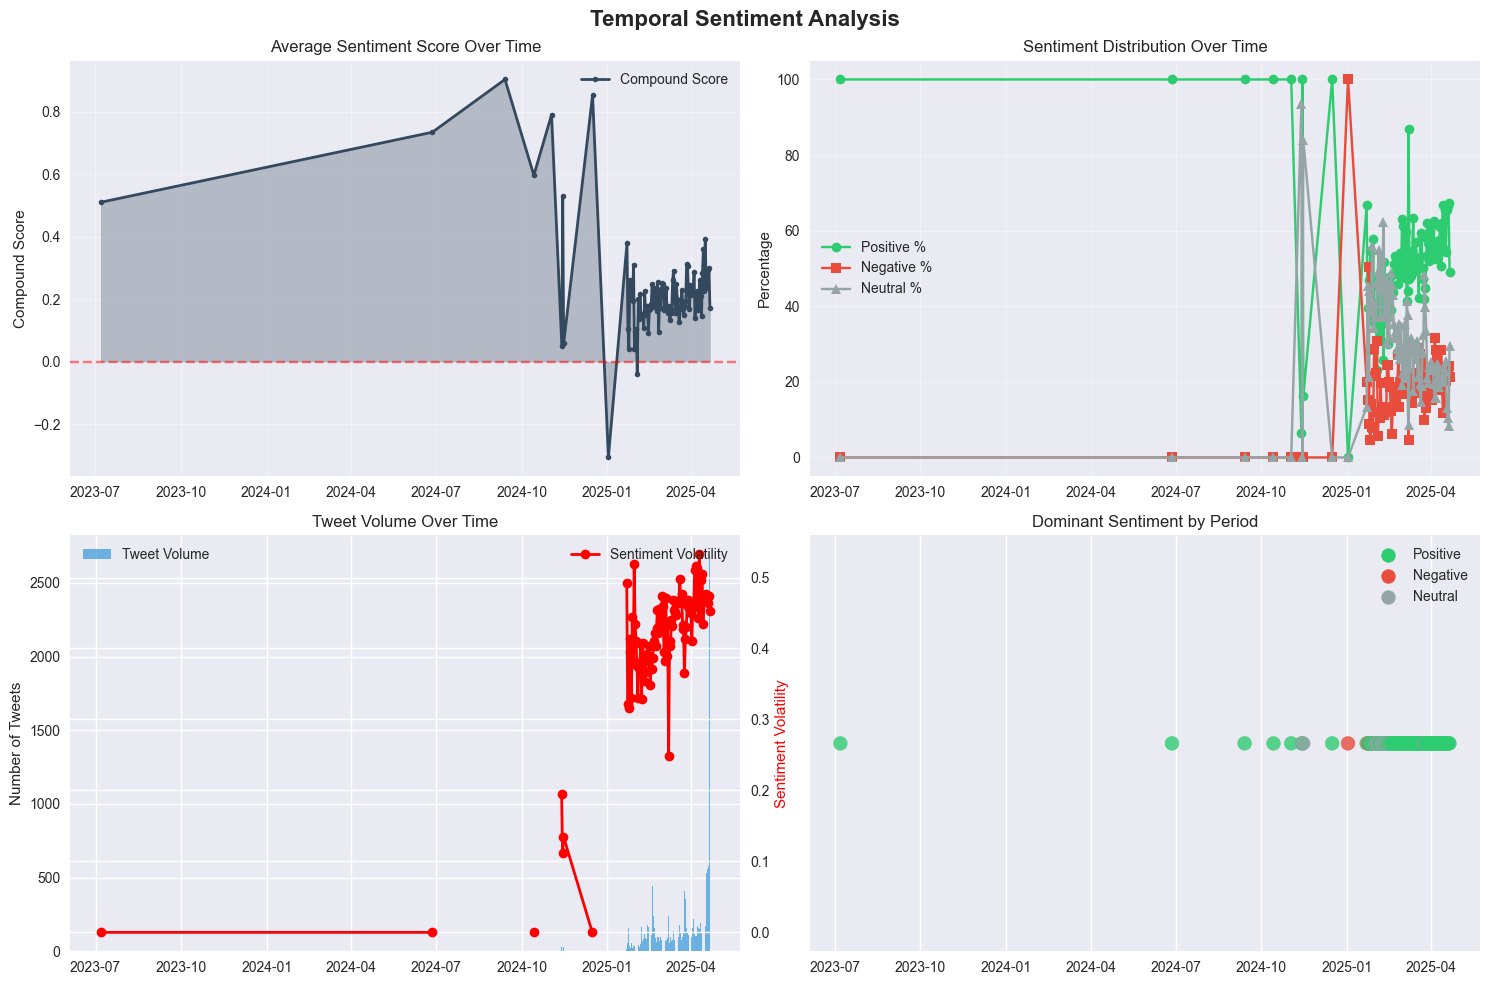

In [43]:
# 1. Temporal Sentiment Analysis
if not temporal_sentiment.empty:
    print("\n📈 Creating temporal sentiment visualization...")
    fig1 = viz.plot_temporal_sentiment(temporal_sentiment, save_path='../plots/temporal_sentiment.png')
    plt.show()
else:
    print("⚠️ Skipping temporal sentiment plot - no data")


👤 Creating user sentiment patterns visualization...
Saved user sentiment patterns plot to ../plots/user_sentiment_patterns.png


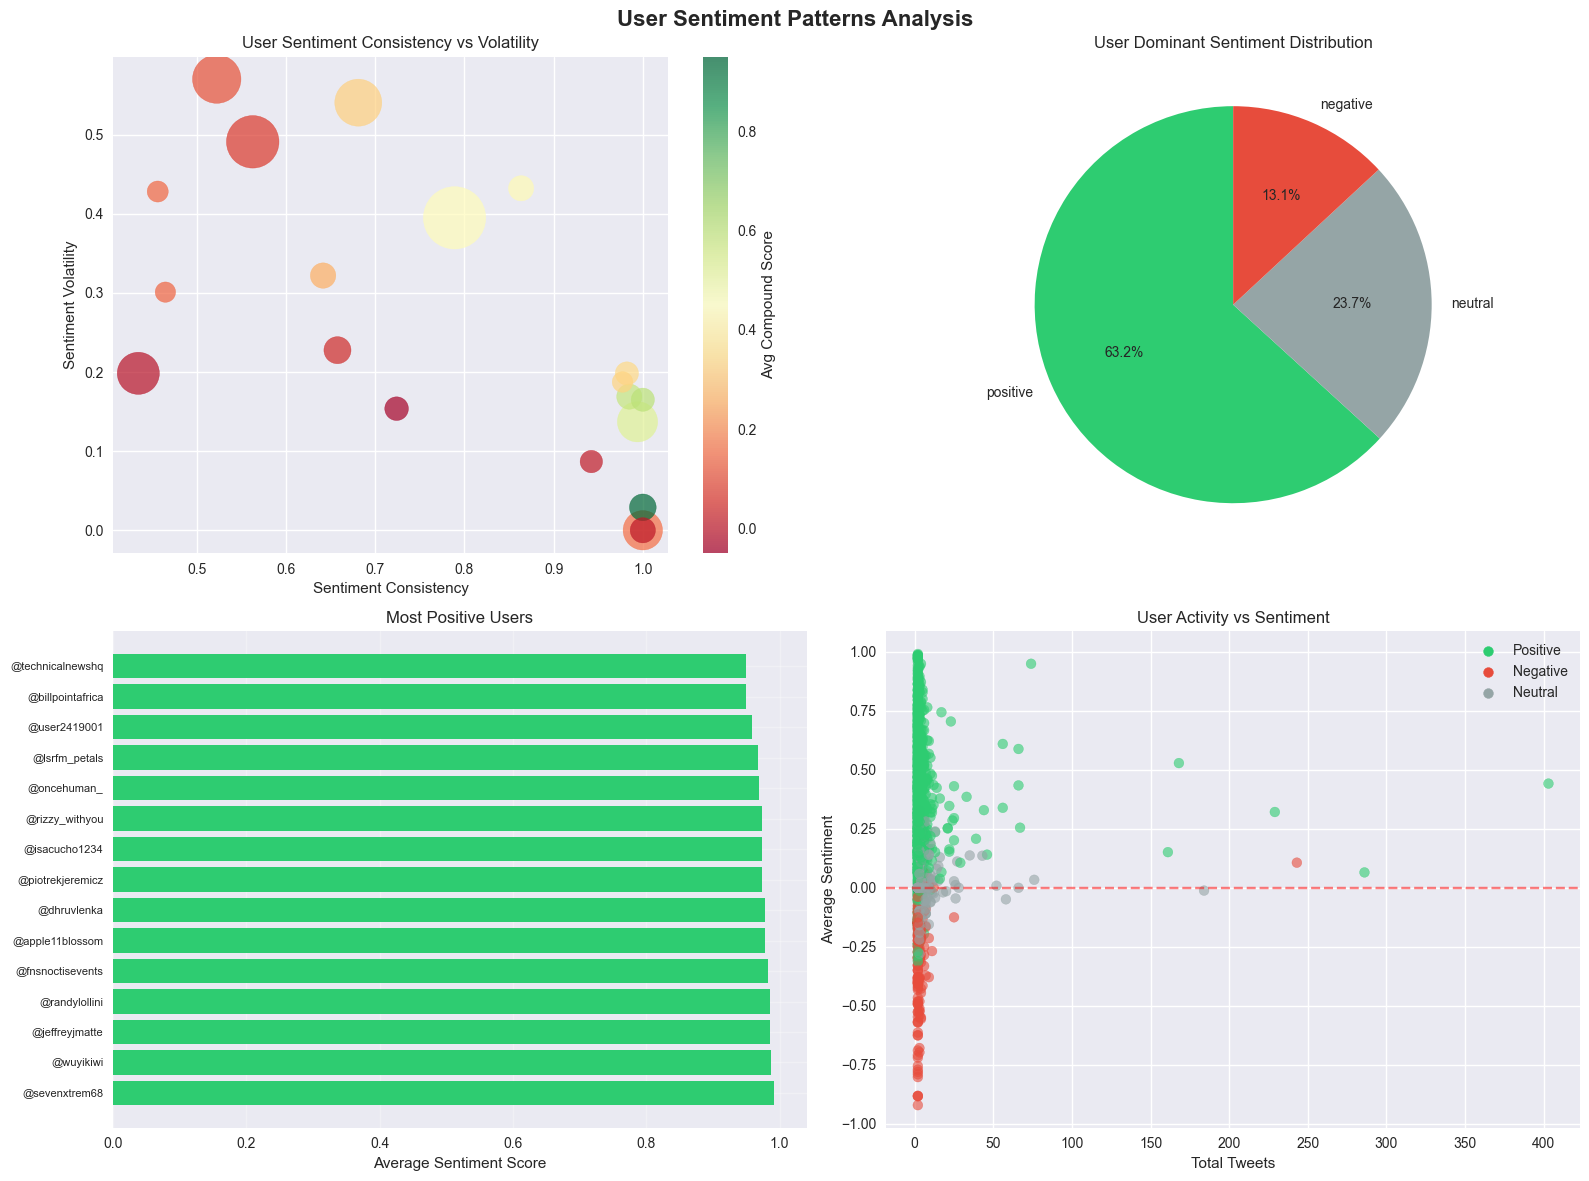

In [44]:
# 2. User Sentiment Patterns
if not user_patterns.empty:
    print("\n👤 Creating user sentiment patterns visualization...")
    fig2 = viz.plot_user_sentiment_patterns(user_patterns, top_n=20, save_path='../plots/user_sentiment_patterns.png')
    plt.show()
else:
    print("⚠️ Skipping user sentiment patterns plot - no data")


🕸️ Creating network graph visualization...
Visualizing all 8053 nodes
Saved network graph to ../plots/network_graph.png


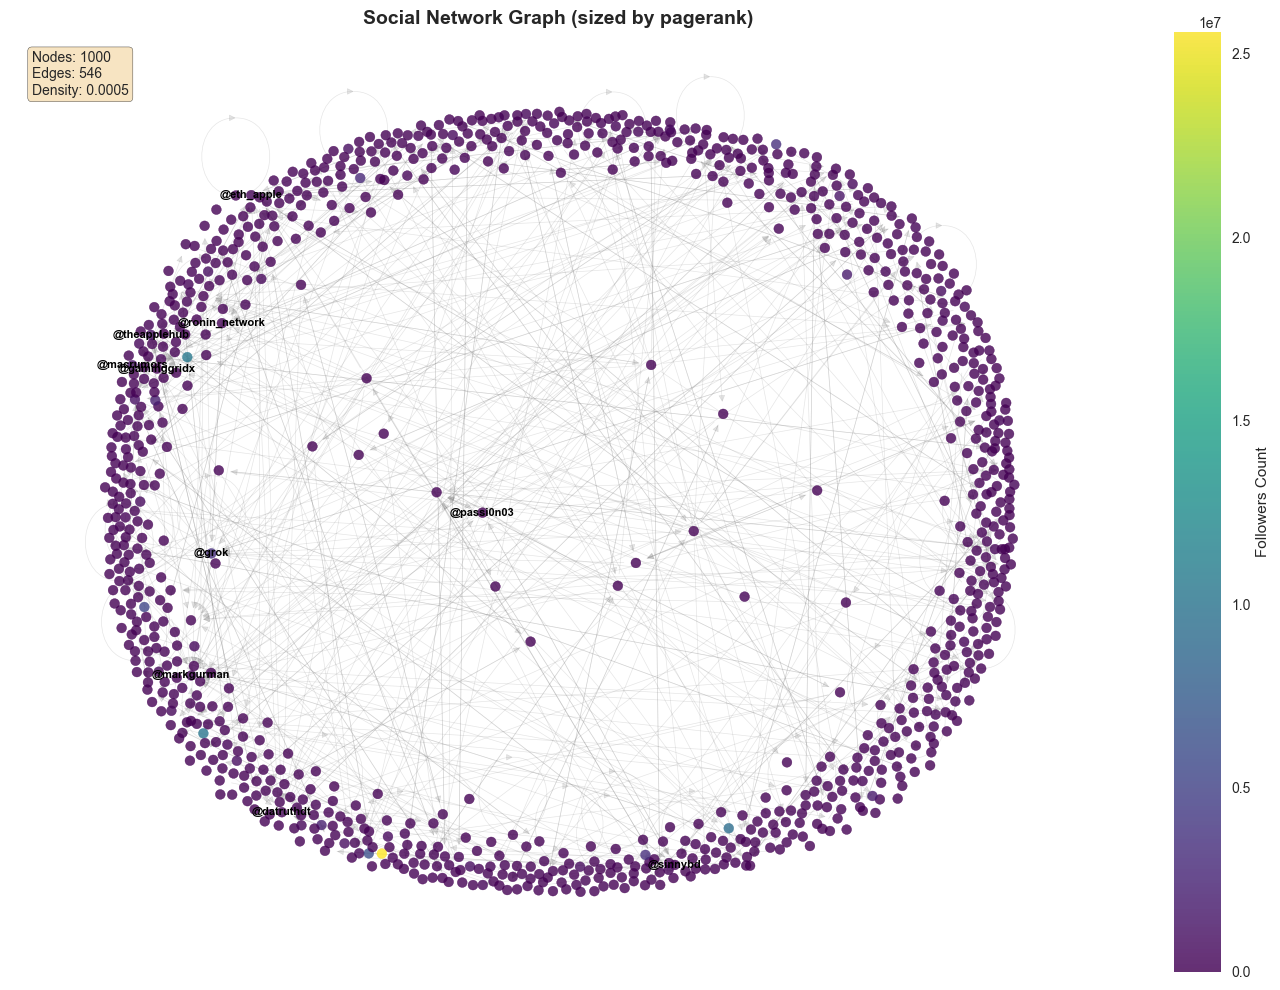

In [45]:
# 3. Network Graph Visualization
if full_graph and full_graph.number_of_nodes() > 0:
    print("\n🕸️ Creating network graph visualization...")
    total_nodes = full_graph.number_of_nodes()
    print(f"Visualizing all {total_nodes} nodes")
    
    fig3 = viz.plot_network_graph(full_graph, layout='spring', node_size_metric='pagerank', 
                                  top_nodes=1000, save_path='../plots/network_graph.png')
    plt.show()
else:
    print("⚠️ Skipping network graph plot - no graph data")


🏆 Creating centrality rankings visualization...
Saved centrality rankings plot to ../plots/centrality_rankings.png


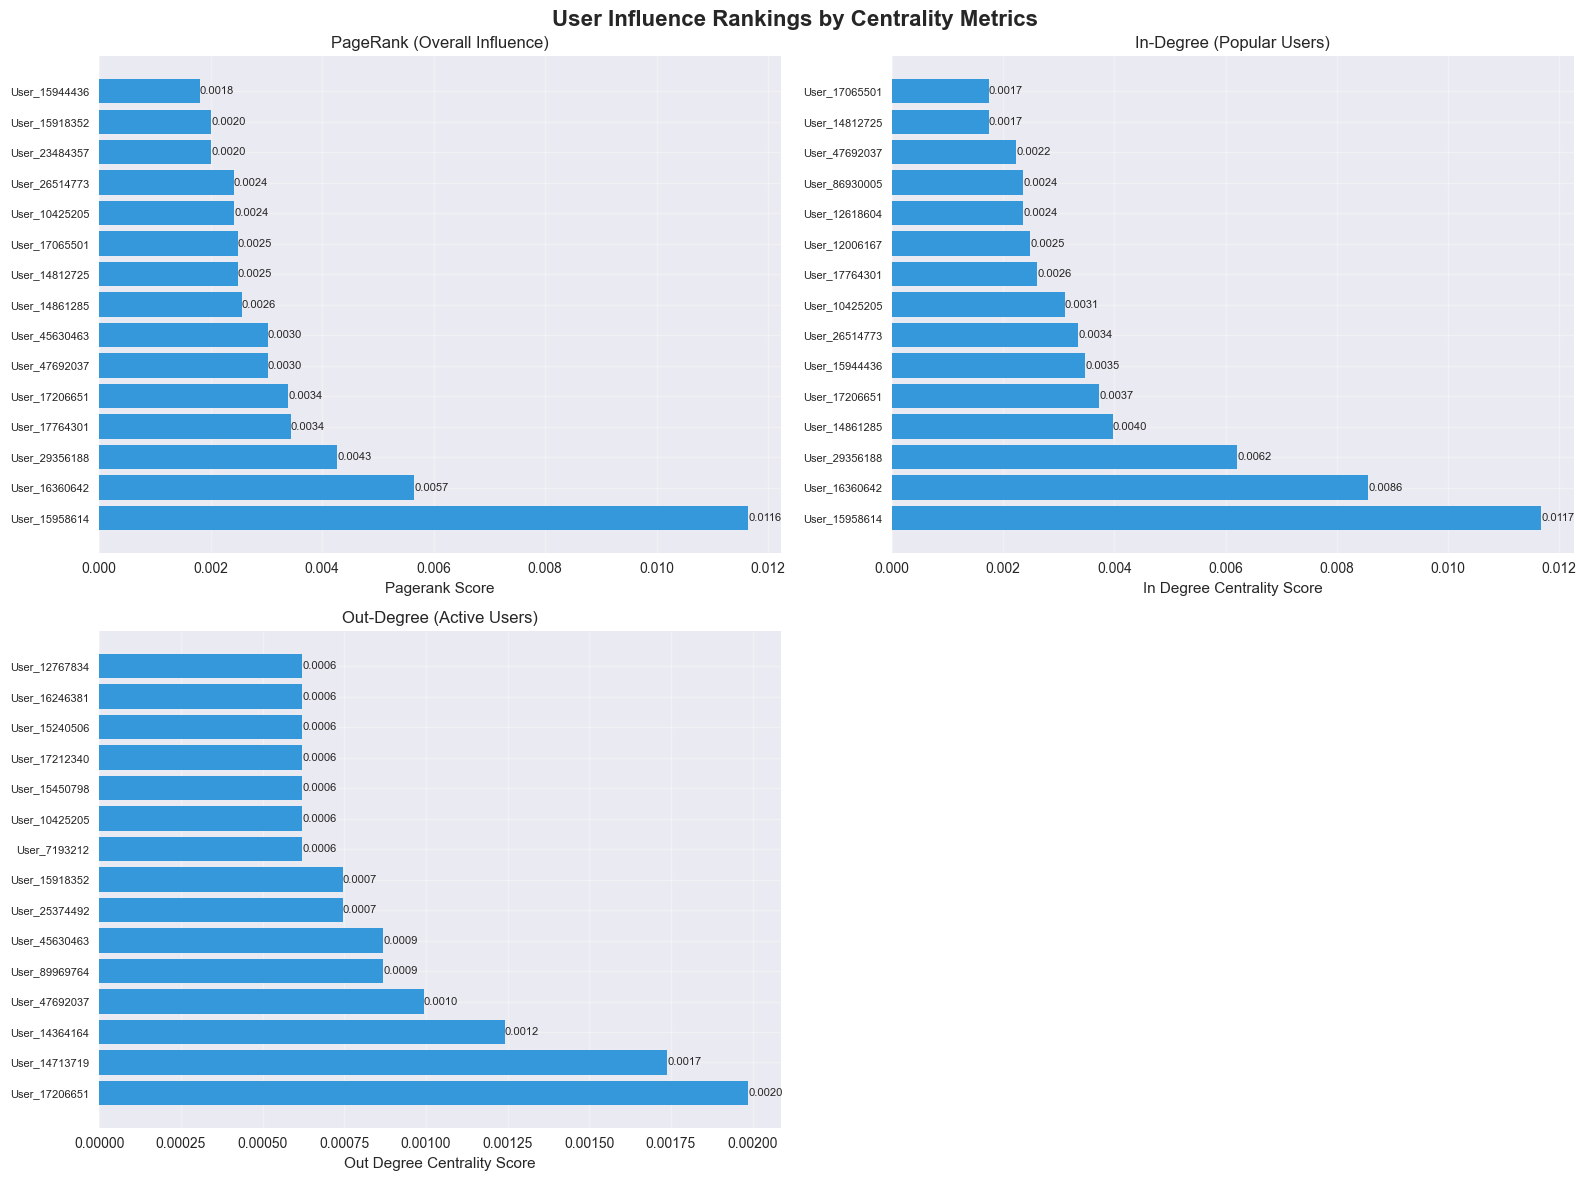

In [46]:
# 4. Centrality Rankings
if centrality_metrics:
    print("\n🏆 Creating centrality rankings visualization...")
    fig4 = viz.plot_centrality_rankings(centrality_metrics, top_k=15, save_path='../plots/centrality_rankings.png')
    plt.show()
else:
    print("⚠️ Skipping centrality rankings plot - no data")


⏰ Creating temporal influence visualization...
Saved temporal influence plot to ../plots/temporal_influence.png


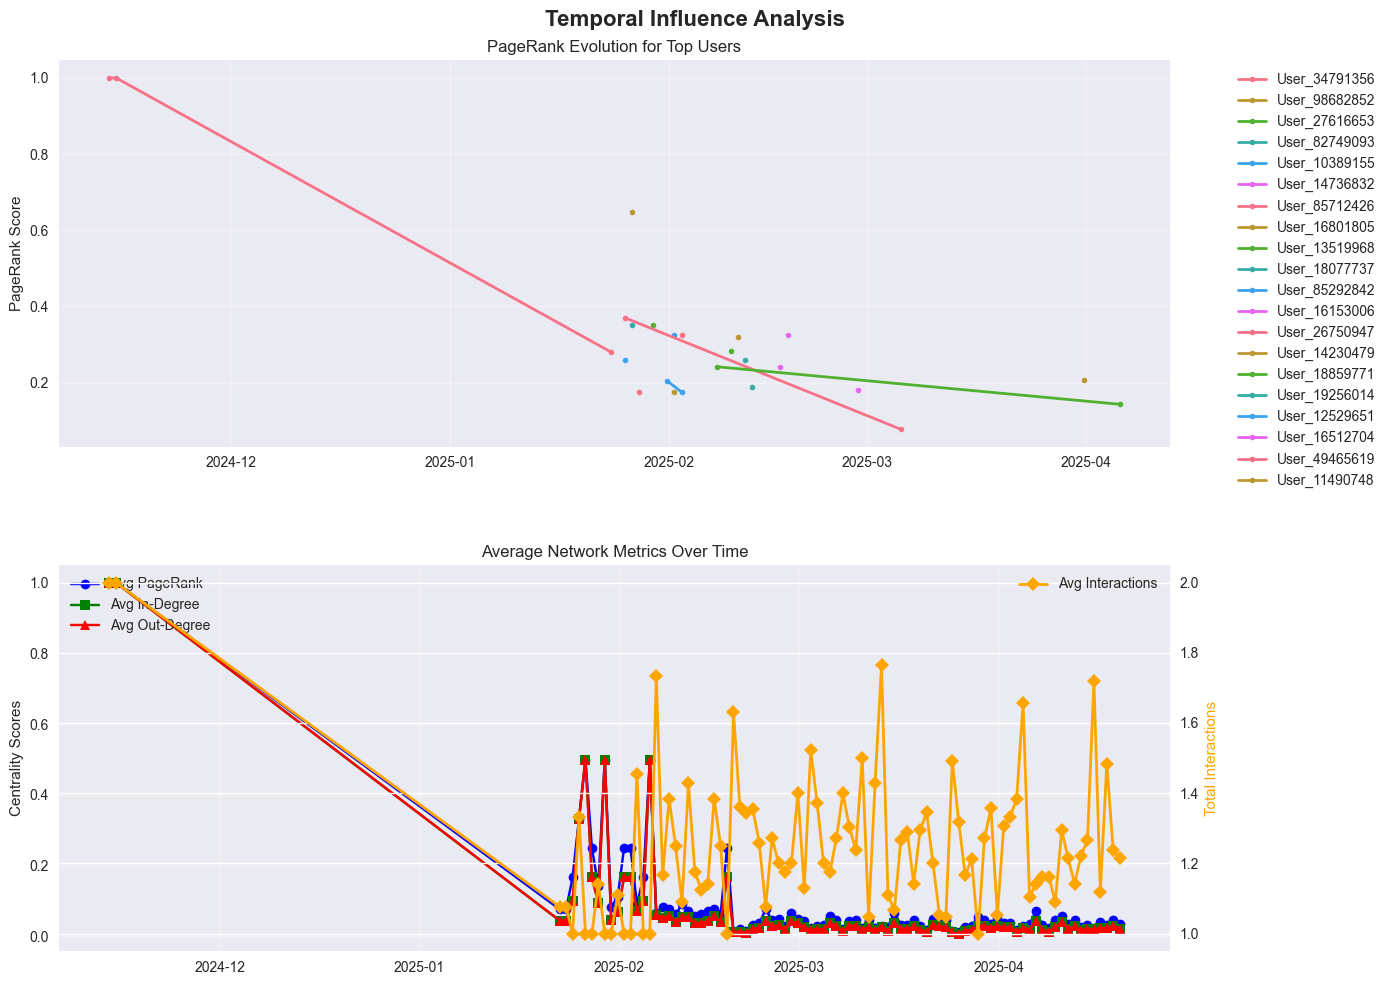

In [47]:
# 5. Temporal Influence Analysis
if not temporal_influence_df.empty:
    print("\n⏰ Creating temporal influence visualization...")
    
    # Quick fix: Convert timestamp format
    if 'timestamp' in temporal_influence_df.columns:
        # Convert timestamp to proper datetime
        try:
            temporal_influence_df['timestamp'] = pd.to_datetime(temporal_influence_df['timestamp'], format='%Y-%m-%d_%H-%M')
        except:
            try:
                temporal_influence_df['timestamp'] = pd.to_datetime(temporal_influence_df['timestamp'])
            except:
                print("Warning: Could not parse timestamps")
    
    # Show more users for better visualization
    total_users = temporal_influence_df['user_id'].nunique()
    users_to_show = min(20, total_users)  # Show up to 20 users
    
    fig5 = viz.plot_temporal_influence(temporal_influence_df, top_users=users_to_show, save_path='../plots/temporal_influence.png')
    plt.show()
else:
    print("⚠️ Skipping temporal influence plot - no data")


🎬 Creating enhanced temporal network snapshots...
Created full graph with 8053 nodes and 1561 edges


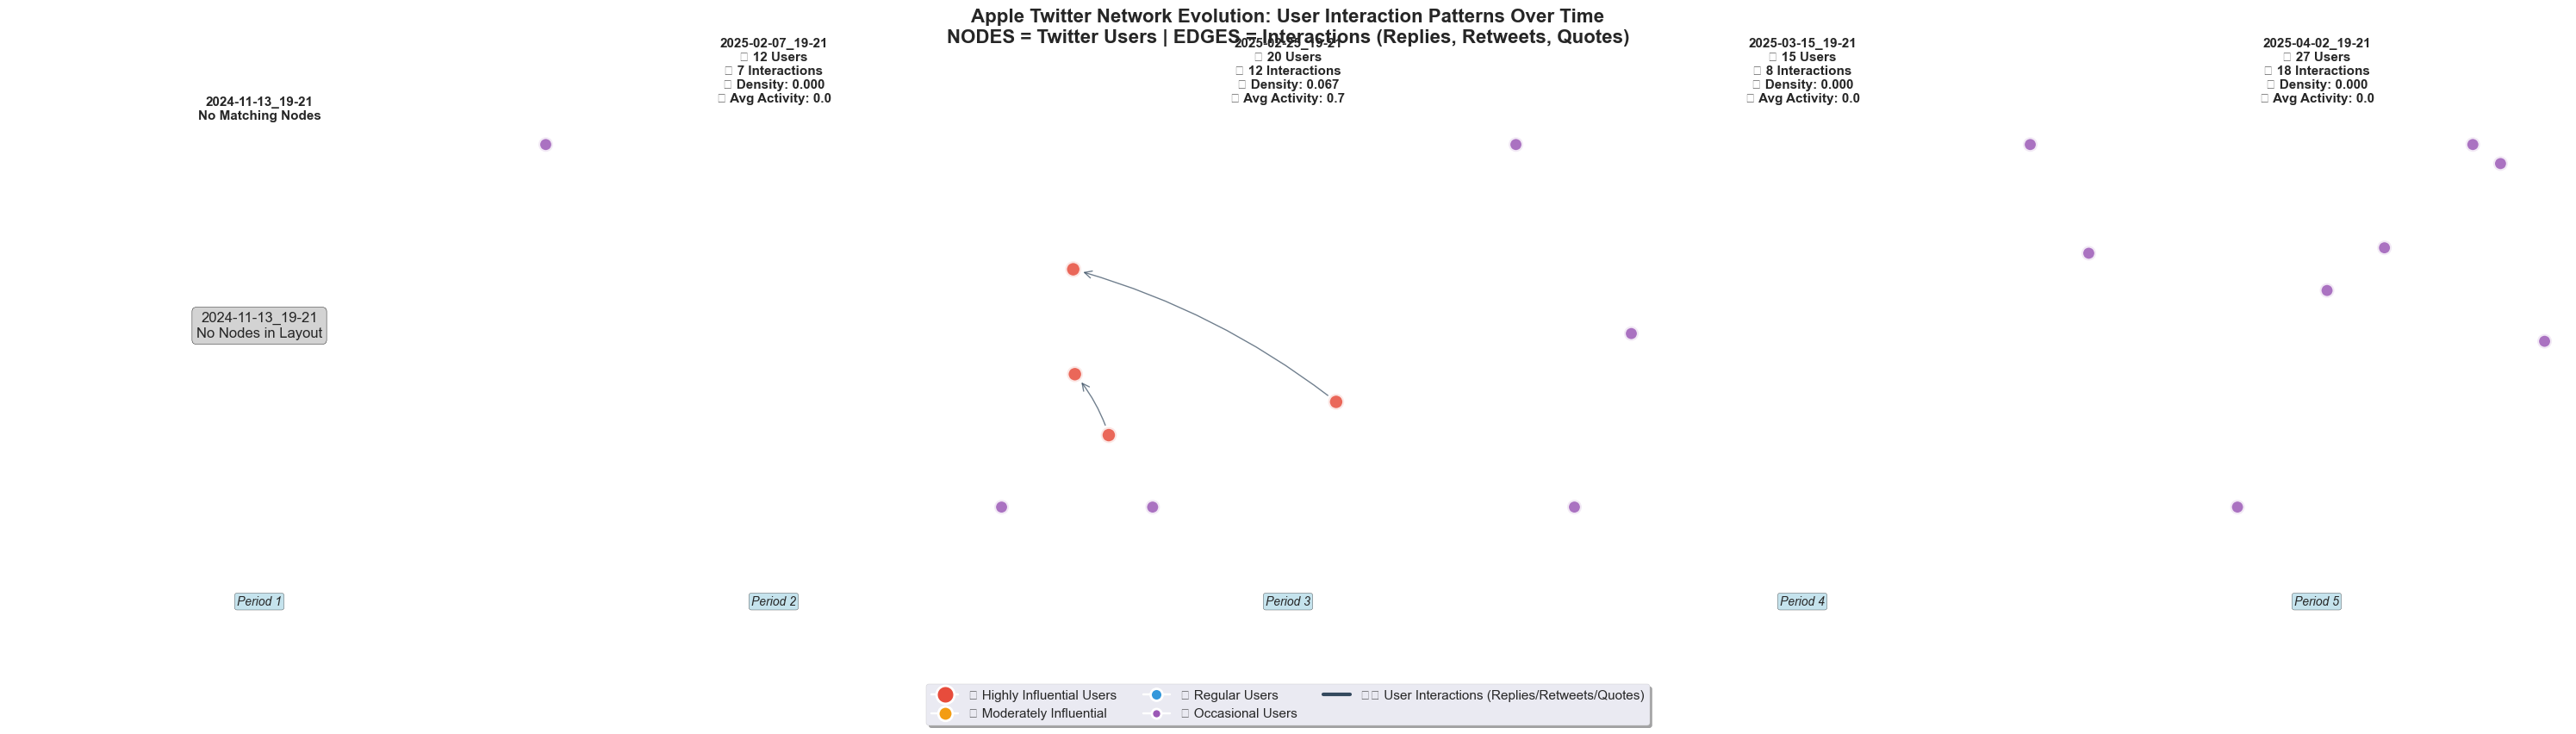


📊 NETWORK VISUALIZATION GUIDE
🔵 NODES (Circles) represent individual Twitter users
   • Node SIZE = User activity level (interactions made/received)
   • Node COLOR = Influence level in the Apple discussion:
     🔴 Red: Highly influential (central to discussions)
     🟠 Orange: Moderately influential
     🔵 Blue: Regular participants
     🟣 Purple: Occasional participants

🔗 EDGES (Arrows) represent user interactions
   • Include: Replies, Retweets, Quote Tweets
   • Arrow direction: A → B means 'A interacted with B'
   • Edge thickness: Frequency of interactions

📈 EVOLUTION PATTERNS:
   Period 1 (2024-11-13_19-21):
     Users: 1, Interactions: 1
     Network density: 0.000, Avg user activity: 2.0
   Period 2 (2025-02-07_19-21):
     Users: 12, Interactions: 7
     Network density: 0.053, Avg user activity: 1.2
   Period 3 (2025-02-25_19-21):
     Users: 20, Interactions: 12
     Network density: 0.032, Avg user activity: 1.2
   Period 4 (2025-03-15_19-21):
     Users: 15, Interactio

In [48]:
# Enhanced temporal snapshots with better visualization
if temporal_graphs and len(temporal_graphs) >= 3:  # Reduced requirement to 3
    print("\n🎬 Creating enhanced temporal network snapshots...")
    
    # Select 3 or 5 time periods based on availability
    time_keys = sorted(temporal_graphs.keys())
    if len(time_keys) >= 5:
        step = max(1, len(time_keys) // 5)
        selected_times = time_keys[::step][:5]
        ncols = 5
    else:
        # If less than 5, take first, middle, last
        selected_times = [time_keys[0], time_keys[len(time_keys)//2], time_keys[-1]]
        ncols = 3
    
    fig, axes = plt.subplots(1, ncols, figsize=(6*ncols, 8))
    if ncols == 1:
        axes = [axes]
    
    # Main title with clear explanation
    fig.suptitle('Apple Twitter Network Evolution: User Interaction Patterns Over Time\n' +
                 'NODES = Twitter Users | EDGES = Interactions (Replies, Retweets, Quotes)', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # Prepare consistent layout
    full_graph = graph_builder.create_full_graph()
    if full_graph.number_of_nodes() > 80:
        degrees = dict(full_graph.degree())
        top_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)[:80]
        layout_graph = full_graph.subgraph(top_nodes)
    else:
        layout_graph = full_graph
    
    master_pos = nx.spring_layout(layout_graph, k=4, iterations=150)
    
    for i, time_key in enumerate(selected_times):
        graph = temporal_graphs[time_key]
        ax = axes[i]
        
        if graph.number_of_nodes() > 0:
            current_nodes = set(graph.nodes()) & set(master_pos.keys())
            if current_nodes:
                subgraph = graph.subgraph(current_nodes)
                pos = {node: master_pos[node] for node in current_nodes}
                
                # Calculate metrics
                degrees = dict(subgraph.degree())
                max_degree = max(degrees.values()) if degrees and degrees.values() else 1  # FIX: Prevent division by zero
                
                # Enhanced node styling
                node_sizes = []
                node_colors = []
                edge_widths = []
                
                for node in current_nodes:
                    degree = degrees[node]
                    degree_ratio = degree / max_degree if max_degree > 0 else 0  # FIX: Safe division
                    
                    # Size based on activity
                    size = min(max(degree * 80 + 100, 150), 800)
                    node_sizes.append(size)
                    
                    # Color based on influence with gradient
                    if degree_ratio > 0.8:
                        node_colors.append('#E74C3C')  # Strong red
                    elif degree_ratio > 0.6:
                        node_colors.append('#F39C12')  # Orange
                    elif degree_ratio > 0.4:
                        node_colors.append('#3498DB')  # Blue
                    elif degree_ratio > 0.2:
                        node_colors.append('#1ABC9C')  # Teal
                    else:
                        node_colors.append('#9B59B6')  # Purple
                
                # Calculate edge widths based on interaction frequency
                edge_widths = []
                for edge in subgraph.edges():
                    weight = subgraph[edge[0]][edge[1]].get('weight', 1)
                    edge_widths.append(min(weight * 0.5 + 0.5, 3))
                
                # Only draw if we have edges, otherwise just draw nodes
                if subgraph.number_of_edges() > 0:
                    # Draw network with enhanced styling
                    nx.draw_networkx_edges(subgraph, pos, ax=ax,
                                         edge_color='#34495E',
                                         alpha=0.7,
                                         width=edge_widths,
                                         arrowsize=15,
                                         arrowstyle='->',
                                         connectionstyle='arc3,rad=0.1')
                
                # Always draw nodes
                nx.draw_networkx_nodes(subgraph, pos, ax=ax,
                                     node_size=node_sizes,
                                     node_color=node_colors,
                                     alpha=0.85,
                                     linewidths=3,
                                     edgecolors='white')
                
                # Add density and activity metrics
                density = nx.density(subgraph)
                avg_degree = sum(degrees.values()) / len(degrees) if degrees else 0
                
                ax.set_title(f'{time_key}\n' +
                           f'👥 {graph.number_of_nodes()} Users\n' +
                           f'🔗 {graph.number_of_edges()} Interactions\n' +
                           f'📊 Density: {density:.3f}\n' +
                           f'⚡ Avg Activity: {avg_degree:.1f}', 
                           fontsize=11, fontweight='bold', pad=20)
            else:
                # No nodes match master layout
                ax.text(0.5, 0.5, f'{time_key}\nNo Nodes in Layout', 
                       ha='center', va='center', transform=ax.transAxes, 
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                ax.set_title(f'{time_key}\nNo Matching Nodes', fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'{time_key}\nNo Network Activity', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax.set_title(f'{time_key}\nNo Activity', fontsize=11, fontweight='bold')
        
        ax.axis('off')
        
        # Add time period indicator
        ax.text(0.5, -0.2, f'Period {i+1}', transform=ax.transAxes, 
               ha='center', fontsize=10, style='italic', 
               bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.7))
    
    # Enhanced legend with detailed explanation
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C', 
                  markersize=15, label='🔥 Highly Influential Users', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F39C12', 
                  markersize=12, label='⭐ Moderately Influential', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498DB', 
                  markersize=10, label='👤 Regular Users', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#9B59B6', 
                  markersize=8, label='💬 Occasional Users', markeredgecolor='white', markeredgewidth=2),
        plt.Line2D([0], [0], color='#34495E', linewidth=3, 
                  label='➡️ User Interactions (Replies/Retweets/Quotes)')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
              bbox_to_anchor=(0.5, -0.1), fontsize=11, frameon=True, 
              fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.savefig('../plots/enhanced_network_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Detailed explanation
    print("\n" + "="*70)
    print("📊 NETWORK VISUALIZATION GUIDE")
    print("="*70)
    print("🔵 NODES (Circles) represent individual Twitter users")
    print("   • Node SIZE = User activity level (interactions made/received)")
    print("   • Node COLOR = Influence level in the Apple discussion:")
    print("     🔴 Red: Highly influential (central to discussions)")
    print("     🟠 Orange: Moderately influential")
    print("     🔵 Blue: Regular participants")
    print("     🟣 Purple: Occasional participants")
    print("\n🔗 EDGES (Arrows) represent user interactions")
    print("   • Include: Replies, Retweets, Quote Tweets")
    print("   • Arrow direction: A → B means 'A interacted with B'")
    print("   • Edge thickness: Frequency of interactions")
    print("\n📈 EVOLUTION PATTERNS:")
    
    for i, time_key in enumerate(selected_times):
        graph = temporal_graphs[time_key]
        if graph.number_of_nodes() > 0:
            density = nx.density(graph)
            degrees_dict = dict(graph.degree())
            avg_degree = sum(degrees_dict.values()) / len(degrees_dict) if degrees_dict else 0
            print(f"   Period {i+1} ({time_key}):")
            print(f"     Users: {graph.number_of_nodes()}, Interactions: {graph.number_of_edges()}")
            print(f"     Network density: {density:.3f}, Avg user activity: {avg_degree:.1f}")
        else:
            print(f"   Period {i+1} ({time_key}): No activity")
    print("="*70)

else:
    print("⚠️ Need at least 3 time periods for temporal snapshots")

## 8. Interactive Dashboard Creation

In [49]:
sentiment_df.columns

Index(['tweet_id', 'user_id', 'username', 'created_at', 'text',
       'text_processed', 'compound', 'positive', 'negative', 'neutral',
       'sentiment_label', 'created_at_parsed'],
      dtype='object')

In [50]:
if not sentiment_df.empty and users:
    sentiment_df_with_followers = sentiment_df.copy()
    followers_list = []
    
    for username in sentiment_df['username']:
        user_followers = 0
        for user_id, user_info in users.items():
            if user_info.get('username') == username:
                user_followers = user_info.get('followers_count', 0)
                break
        followers_list.append(user_followers)
    
    sentiment_df_with_followers['followers_count'] = followers_list
    
    # Now create dashboard with the enhanced dataframe
    interactive_fig = viz.create_interactive_sentiment_dashboard(
        temporal_sentiment, sentiment_df_with_followers, 
        save_path='../plots/interactive_dashboard.html'
    )
    if interactive_fig:
        print("✅ Interactive sentiment dashboard created successfully!")
        interactive_fig.show()
    else:
        print("❌ Failed to create interactive sentiment dashboard.")

Saved interactive dashboard to ../plots/interactive_dashboard.html
✅ Interactive sentiment dashboard created successfully!


🔄 Initializing advanced temporal pattern mining...
Processing 91 temporal snapshots...
✅ Advanced temporal features extracted: 91 snapshots
📊 Generating comprehensive temporal pattern report...
🔄 Analyzing daily/weekly network patterns...
🔄 Clustering network states into 5 patterns...
🔄 Predicting optimal information dissemination times...
🔄 Detecting recurring temporal patterns...

📊 Advanced Pattern Analysis:
   Analysis period: 159 days
   Total snapshots: 91

📈 Creating temporal pattern visualizations...


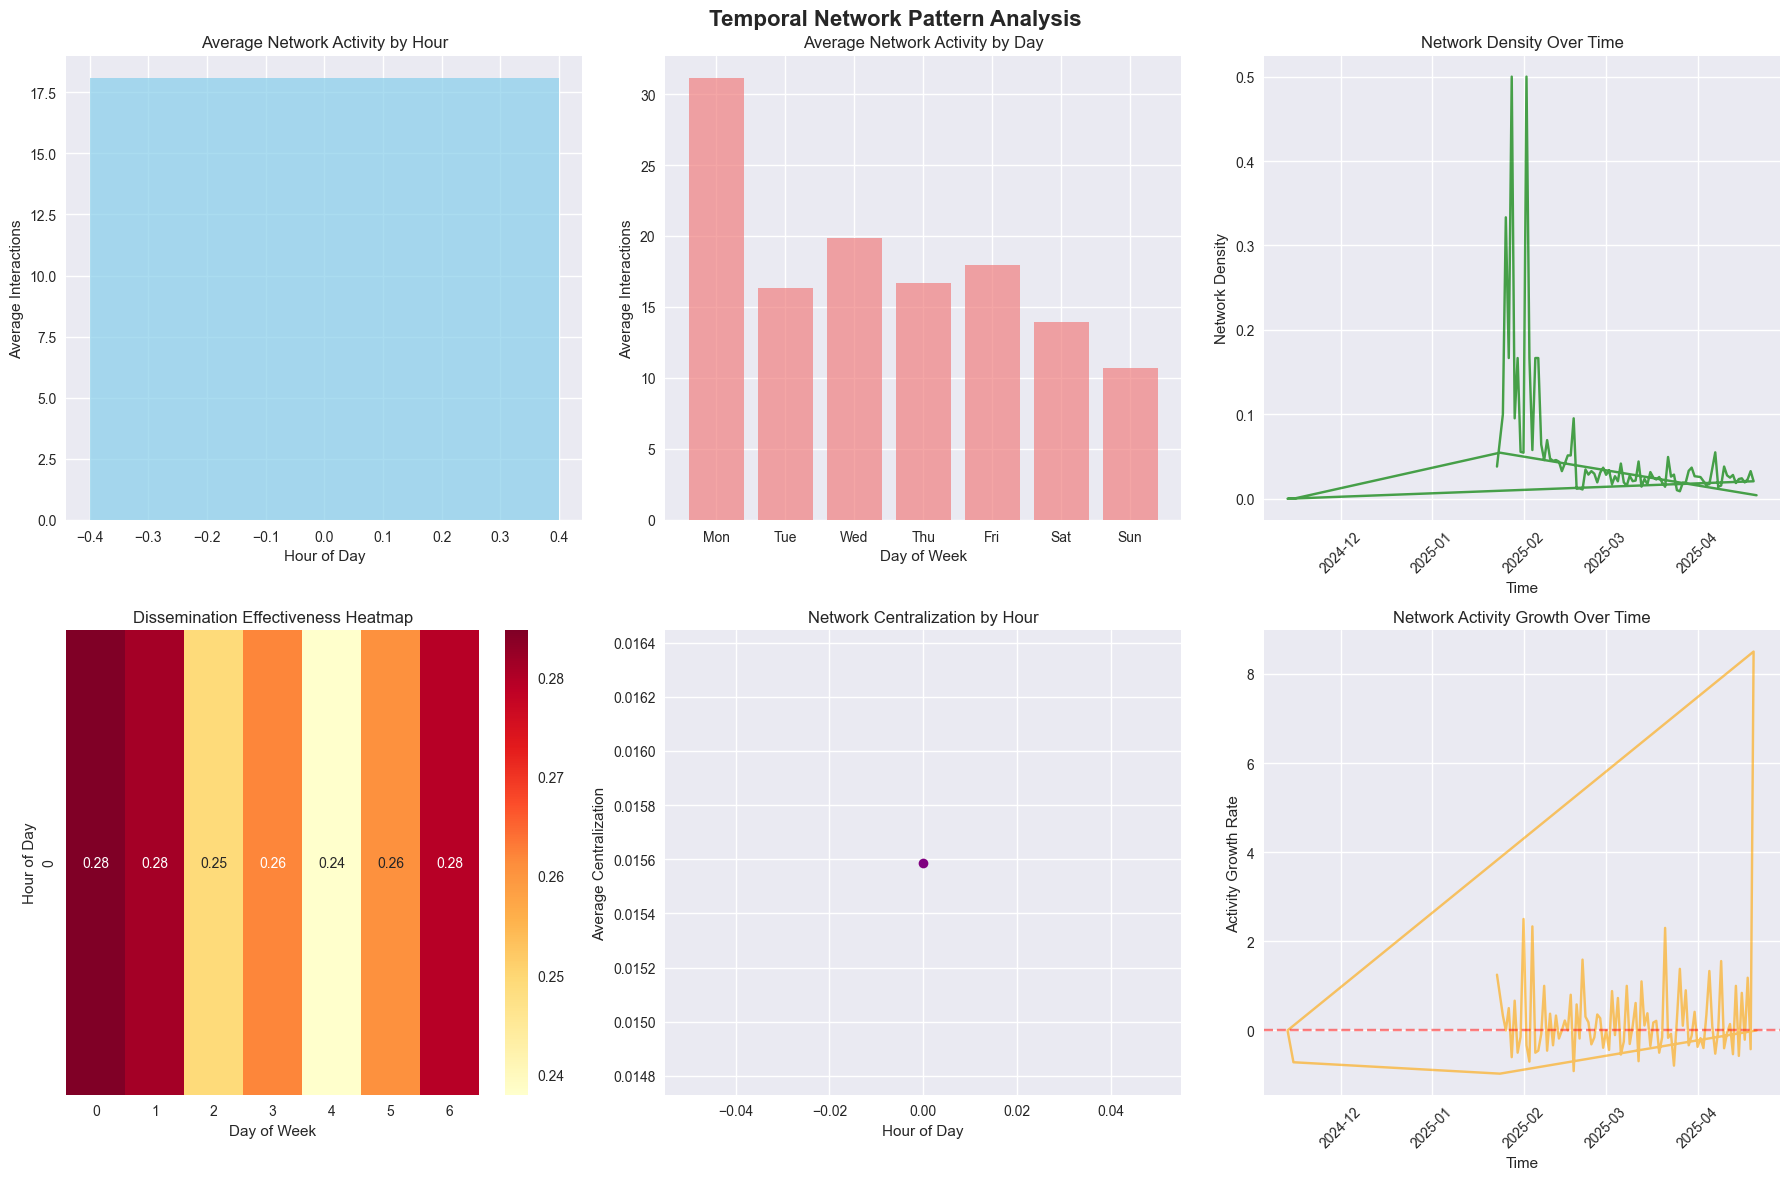

✅ Ready for dissemination optimization!


In [6]:
# Advanced temporal pattern mining using the custom module
sys.path.append('../src')
from temporal_pattern_mining import TemporalPatternMiner

print("🔄 Initializing advanced temporal pattern mining...")

# Initialize the pattern miner
pattern_miner = TemporalPatternMiner(temporal_graphs, interactions)

# Extract comprehensive temporal features
temporal_features_df = pattern_miner.extract_temporal_features()

if not temporal_features_df.empty:
    print(f"✅ Advanced temporal features extracted: {len(temporal_features_df)} snapshots")
    
    # Generate comprehensive pattern report
    pattern_report = pattern_miner.generate_pattern_report(temporal_features_df)
    
    print(f"\n📊 Advanced Pattern Analysis:")
    print(f"   Analysis period: {pattern_report['analysis_period']['duration_days']} days")
    print(f"   Total snapshots: {pattern_report['analysis_period']['total_snapshots']}")
    
    
    # Create visualizations
    print(f"\n📈 Creating temporal pattern visualizations...")
    viz_fig = pattern_miner.visualize_patterns(temporal_features_df, 
                                               save_path='../plots/temporal_patterns.png')


print("✅ Ready for dissemination optimization!")


🎯 OPTIMAL INFORMATION DISSEMINATION TIMES

📅 TOP 5 RECOMMENDED TIME SLOTS:
1. Wednesday
   Effectiveness Score: 0.349
   Confidence Level: High
   Expected Reach: 19.8 interactions

2. Monday
   Effectiveness Score: 0.342
   Confidence Level: High
   Expected Reach: 31.2 interactions

3. Sunday
   Effectiveness Score: 0.341
   Confidence Level: High
   Expected Reach: 10.7 interactions

4. Saturday
   Effectiveness Score: 0.332
   Confidence Level: High
   Expected Reach: 13.9 interactions

5. Friday
   Effectiveness Score: 0.325
   Confidence Level: High
   Expected Reach: 17.9 interactions


👥 AUDIENCE-SPECIFIC RECOMMENDATIONS:
Mass Audience:
  Optimal Days: Monday, Saturday, Wednesday
  Sample Size: 38 observations
Engaged Audience:
  Optimal Days: Sunday, Wednesday, Tuesday
  Sample Size: 37 observations
Balanced Dissemination:
  Optimal Days: Wednesday, Sunday, Monday
  Sample Size: 19 observations

📊 Creating enhanced dissemination dashboard...


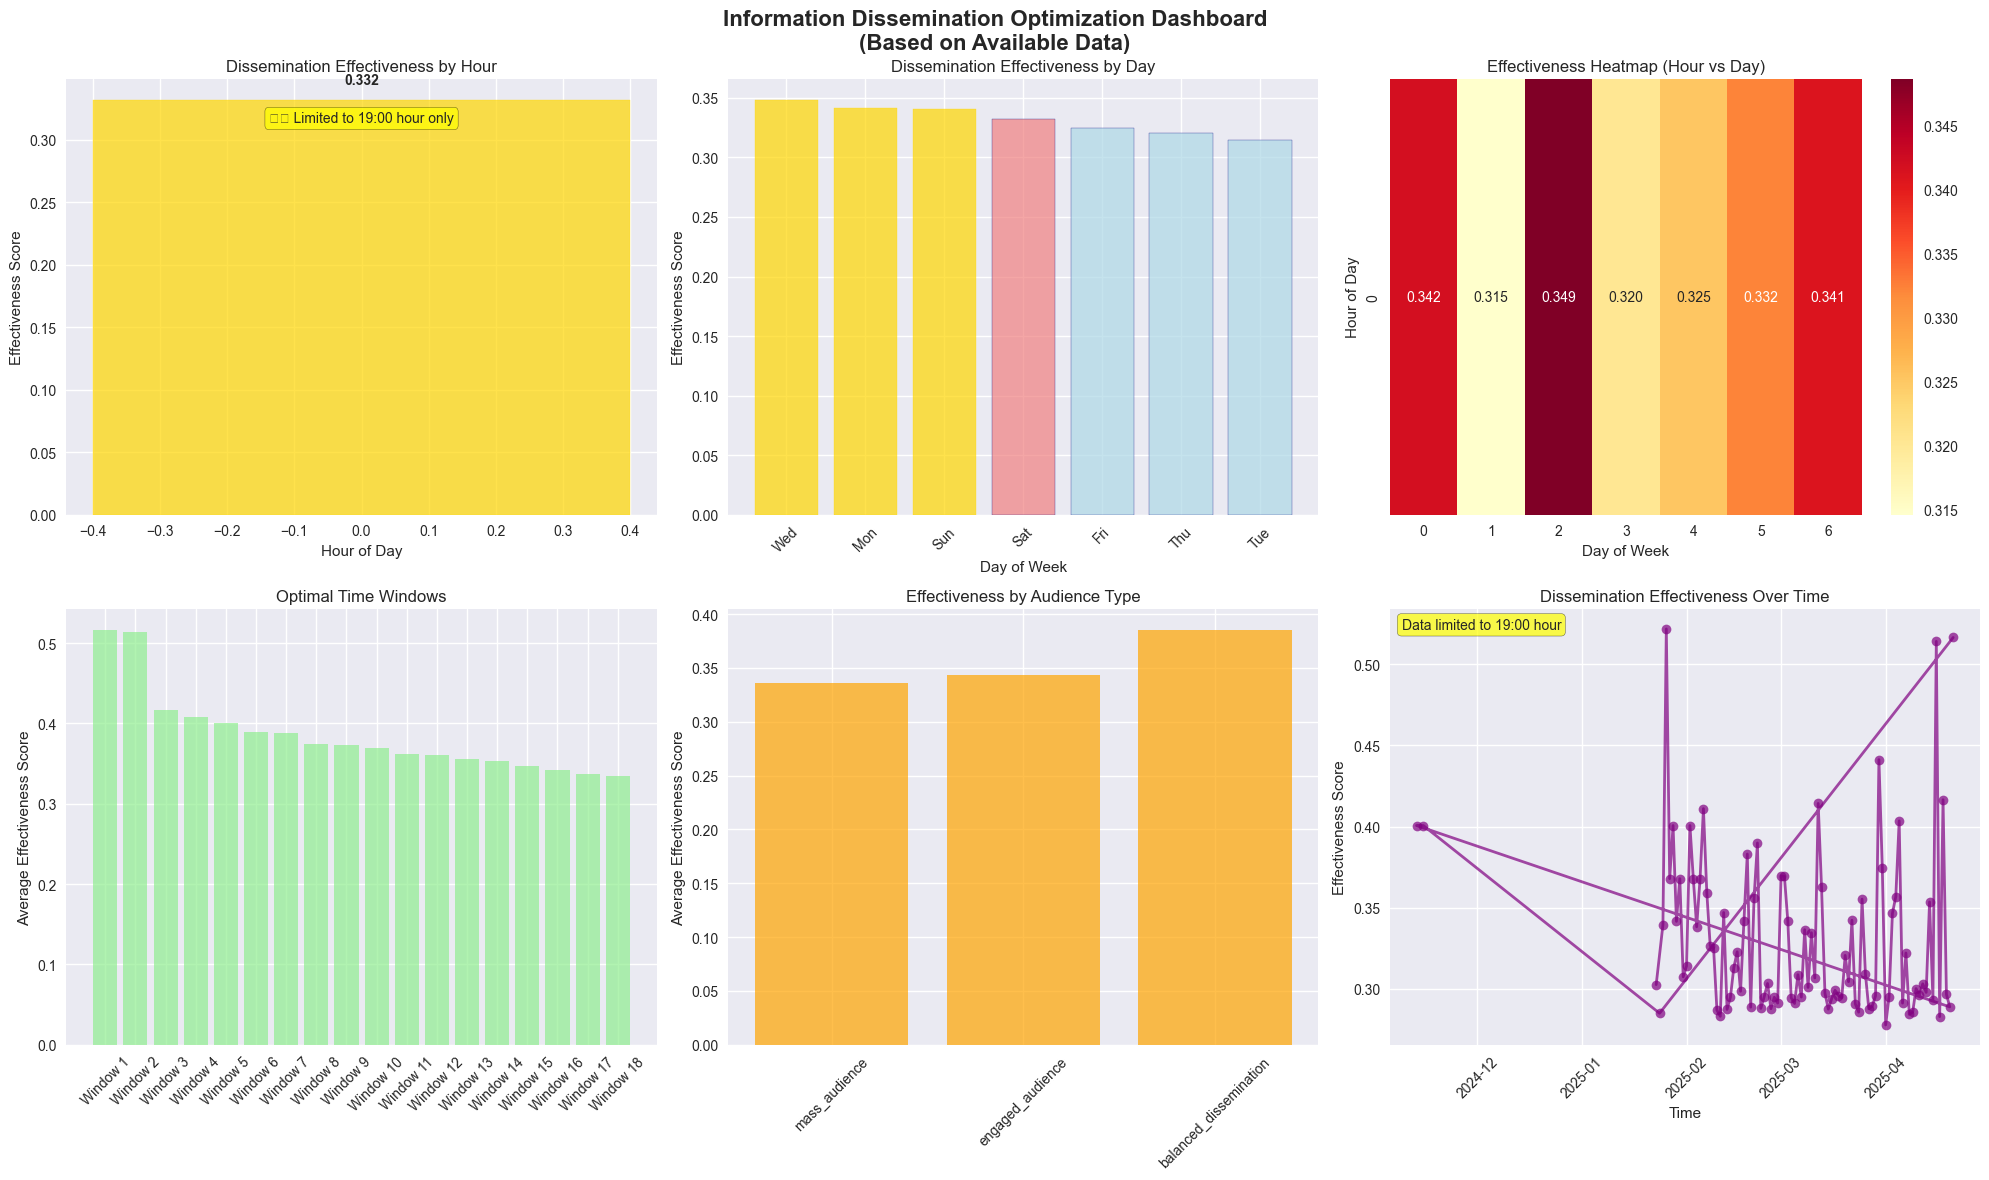

In [ ]:
from dissemination_optimizer import InformationDisseminationOptimizer

dissemination_optimizer = InformationDisseminationOptimizer(temporal_features_df, pattern_report)

recommendations = dissemination_optimizer.generate_recommendations()

print("🎯 OPTIMAL INFORMATION DISSEMINATION TIMES")
print("=" * 60)

print("\n📅 TOP 5 RECOMMENDED TIME SLOTS:")
if recommendations['top_time_slots']:
    for i, slot in enumerate(recommendations['top_time_slots'][:5], 1):
        print(f"{i}. {slot['time_slot'].split()[0]}")
        print(f"   Effectiveness Score: {slot['effectiveness_score']:.3f}")
        print(f"   Confidence Level: {slot['confidence']}")
        print(f"   Expected Reach: {slot['expected_reach']:.1f} interactions\n")
else:
    print("   No specific time slots identified due to limited data")


print("\n👥 AUDIENCE-SPECIFIC RECOMMENDATIONS:")
audience_recs = recommendations['audience_specific_recommendations']
if audience_recs:
    for audience_type, data in audience_recs.items():
        if 'optimal_hours' in data and data['optimal_hours']:
            print(f"{data['audience_type']}:")
            print(f"  Optimal Days: {', '.join(data['optimal_days'])}")
            print(f"  Sample Size: {data.get('sample_size', 'N/A')} observations")
        else:
            print(f"{audience_type}: No specific patterns identified")
else:
    print("No audience-specific recommendations available")


print("\n📊 Creating enhanced dissemination dashboard...")
dashboard_fig = dissemination_optimizer.create_dissemination_dashboard(
    save_path='../plots/dissemination_optimization_dashboard.png'
)